# Take Your Shot
## Final Submission
### Jacob Brown, Avery Smith, and Kyle Salisbury
#### Video Presentation Link: https://www.youtube.com/watch?v=HDrmcKn1qhI

Members | email | uid
--------|-------|-----------
Jacob Brown | u0729080@utah.edu | u0729080
Avery Smith | averyjs@gmail.com | u0838931
Kyle Salisbury | Kcsals@gmail.com |  u0711328

### Primary Questions:

What are the natural groupings/clusters of shots on a basketball court? 

Which combinations of player and shooting location have the highest expected value (shooting pct * points)? 

Are the differences in shooting percentage statistically significant? 

How does shooting pct vary at Home vs. Away?

Given only the location and shooters for a game not in our dataset, can we predict the final score of the Jazz, the amount of points each player scored, and whether or not they won?



## Accomplished:
 - Web scraped all data from sources and created "final" csv
 
 - Obtained key data points using Regex
 
 - Cleaned data and created various dataframes
 
 - Unsupervised clustering (k-means) to divide court into 6 clusters (futher divided by 2 pointer and 3 pointer)
 
 - Calculated expected value for each player in each court position and reported them on shot charts
 
 - Calculated significance for shooting percentages by player and location
 
 - Explored expected value difference for Home VS Away games
 
 - Predicted the score of Jazz game, along with individual player totals. 





### Methods Used:
 - Web scraping
 
 - Regex
 
 - Dataframes (including masking)
 
 - Unsupervised clustering (k-means)
 
 - Loops and logic
 
 - Hypothesis Testing
 
 - Visualizations (Scatter plots, heat maps)
 
 - Predictions via pseduo-model 

## Programming and Methods:

In [3]:
# Import All Library Packages

from bs4 import BeautifulSoup 
import requests
import urllib.request
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
import math
import scipy as sc
from scipy.stats import norm

# Develop some color maps
seven_colors = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8","#ffff33","#4daf4a","#ff7f00"])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

# Load in the court picture
img = plt.imread('JazzCortHalf.png')

### Data Aquisition Process
#### (This may take quite a while to run. It also saves local htmls so it is suggested, if running the code, to start later at Exploratory Analysis section)

We scraped shot charts for the Utah Jazz from http://www.espn.com .  We used the hyperlinks on the Jazz schedule page to find all the Jazz games for the entire season.  We saved each page as a .html file so we could interact with them without having to scrape them over and over again.

In [ ]:
# Function to get soups for a given URL
def getWebsiteAsSoup(url):
    """ 
    Retrieve a website and return it as a BeautifulSoup object.   
    """
 
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req) as response:
        classlist_html = response.read()
    
    class_soup = BeautifulSoup(classlist_html, 'html.parser')
    with open('class_list.html', 'w') as new_file:
        new_file.write(str(class_soup))
        
    return class_soup

In [ ]:
# url for the jazz schedule
schedule_url = "http://www.espn.com/nba/team/schedule/_/name/utah/utah-jazz"
schedule_soup = getWebsiteAsSoup(schedule_url)
base_url = "http://www.espn.com/nba/game?gameId="  # append url_endings to this
url_endings = []
regex = '//www.espn.com/nba/recap/_/id/(\d+)"'
for a_element in schedule_soup.find_all('a'):  # find all elements of type 'a'
    ending = re.findall(regex, str(a_element))
    if ending != []:  # many of these elements won't contain the regular expression--skip them
        url_endings.append(ending[0])

print('Number of Jazz Games:')
print(len(url_endings))  # shows how many games the Jazz have played so far

In [ ]:
# Function to save html for a given URL
def saveWebsiteToLocal(url, number):
    """ 
    Retrieve a website and save it locally as an html.  
    """
 
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req) as response:
        classlist_html = response.read()
    
    # print(classlist_html)
    
    class_soup = BeautifulSoup(classlist_html, 'html.parser')
    with open('html/game_' + str(number) + '.html', 'w') as new_file:
        new_file.write(str(class_soup))
        
    return

In [ ]:
# download all the games to a local copy
i = 1
for game in url_endings:
    saveWebsiteToLocal(base_url+url_endings[i-1], i)
    i+=1
    time.sleep(10)

### Data Processing

The following image was screenshotted from the url http://www.espn.com/nba/game?gameId=400975701 .  Each of the dots is an element of type 'li' which can be scraped.

![ESPN Shot Chart](ShotChart.png)

We used beautiful soup to identify the html element for each shot, and used regular expressions to extract the interesting data from each shot. This is what the HTML looks like. We were mostly interested in data-text, data-homeaway, data-shooter, and left and top positions. 

![HTML for Shot Chart](Inspection of HTML.jpeg)

In [4]:
# regular expressions to obtain key data
utah_regex = 'utah.png'
made_missed_regex = r'class="(\w+)"'
period_regex = r'data-period="(\d)"'
shooter_regex = r'data-shooter="(\d+)"'
blocks_regex = r'blocks'
blocks_shooter_name_regex = r"blocks (\w+ \w+)"
shooter_name_regex = r'data-text="(\w+ \w+)'
distance_regex = r' (\d+-foot)'
type_regex = r'foot ([\w ]+)[ "]'
alt_type_regex = r'e*s ([\w ]+)["\(]'
assist_regex = r'\((\w+ \w+) assists\)'
left_regex = r'left:(\d+.\d+)%'
top_regex = r'top:(\d+.\d+)%'
three_regex = r'three'

In [5]:
# Obtaining key words from scraping
start = time.clock()
array = []
tot_games = 80
for i in range(1, tot_games+1):
    GameWebsite = BeautifulSoup(open("html/game_" + str(i) + ".html"), "html.parser")
    court_symbol = GameWebsite.select('.shot-chart > .team-logo')
    home_team = re.findall(utah_regex, str(court_symbol))
    if home_team:        
        AllJazzShots = GameWebsite.find_all(class_="shots home-team")[0]
        homeaway = 1
    else:
        AllJazzShots = GameWebsite.find_all(class_="shots away-team")[0]
        homeaway = 0
    for j in range(0, 300):
        Shot = AllJazzShots.find(id="shot" + str(j))
        if Shot == None:
            continue
        game = i
        shot = j
        made_missed = re.findall(made_missed_regex, str(Shot))[0]
        if made_missed == "made":
            made_missed = 1
        else:
            made_missed = 0
        period = re.findall(period_regex, str(Shot))[0]
        shooter =  re.findall(shooter_regex, str(Shot))[0]
        block = re.findall(blocks_regex, str(Shot))
        shooter_name = re.findall(shooter_name_regex, str(Shot))
        if block:
            shooter_name = re.findall(blocks_shooter_name_regex, str(Shot))[0]
        elif shooter_name == []:
            shooter_name = None
        else:
            shooter_name = shooter_name[0]
        distance = re.findall(distance_regex, str(Shot))
        if distance == []:
            distance = None
        else:
            distance = distance[0]
        shot_type = re.findall(type_regex, str(Shot))
        if shot_type == []:
            shot_type = re.findall(alt_type_regex, str(Shot))
            #if shot_type == []:
            #    shot_type = "deviant"
        shot_type = shot_type[0]
        # clears out some problems associated with greedy regex        
        start = shot_type.find("makes ") + len("makes ")
        if start >= len("makes "):
            shot_type = shot_type[start:]
        start = shot_type.find("misses ") + len("misses ")
        if start >= len("misses "):
            shot_type = shot_type[start:]
        assist = re.findall(assist_regex, str(Shot))
        if assist == []:
            assist = None
        else:
            assist = assist[0]
        left = float(re.findall(left_regex, str(Shot))[0])
        # one axis needs to be flipped depending on if it is home or away
        if (homeaway == 0):
            left = 100-left
            #print('away')
        top = float(re.findall(top_regex, str(Shot))[0])
        if homeaway:
            top = 100-top
        three = re.findall(three_regex, shot_type)
        if three == []:
            three = 0
        else:
            three = 1
        game_array = [game, shot, homeaway, made_missed, period, shooter, shooter_name, distance, shot_type, 
                     assist, left, top, three]
        array.append(game_array)
end = time.clock()
print("This took " + str(end-start) + " seconds to run")

This took 41.315738 seconds to run


In [6]:
columns = ["game", "shot", "home/away", "made/missed", "period", "shooter", "shooter_name", 
           "distance", "shot_type", "assist", "left", "top", "ThreePt"]
print('Total Number of Shots: ' + str(len(array)))  # total number of shots
print('Average Shots Per Game: ' + str(len(array)/tot_games))  # avg shots per game

Total Number of Shots: 6630
Average Shots Per Game: 82.875


In [7]:
panda_dataframe = pd.DataFrame(array, columns=columns)
panda_dataframe.head()

,game,shot,home/away,made/missed,period,shooter,shooter_name,distance,shot_type,assist,left,top,ThreePt
0,1,0,0,0,1,4011,Ricky Rubio,17-foot,pullup jump shot,None,76.666667,58.0,0
1,1,1,0,1,1,2968436,Joe Ingles,24-foot,three point shot,Donovan Mitchell,90.000000,2.0,1
2,1,2,0,1,1,3908809,Donovan Mitchell,None,dunk,Ricky Rubio,94.444444,50.0,0
3,1,3,0,1,1,3032976,Rudy Gobert,None,dunk,Derrick Favors,95.555556,50.0,0
4,1,4,0,0,1,4011,Ricky Rubio,None,two point shot,None,95.555556,52.0,0


In [8]:
panda_dataframe.to_csv("shots_dataframe_final.csv")

# Exploratory Analysis
#### Data can be read from here without having to run the top half of the notebook - (which could take a while)

In [9]:
# data can be read from here without having to run the top half of the notebook
# (which could take a while)
ShotsPD = pd.read_csv("shots_dataframe.csv")

In [10]:
# Describe Data Set
ShotsPD.describe()

,Unnamed: 0,game,shot,home/away,made/missed,period,shooter,left,top,ThreePt
count,6793.000000,6793.000000,6793.000000,6793.000000,6793.000000,6793.000000,6.793000e+03,6793.000000,6793.000000,6793.000000
mean,3396.000000,41.636096,49.889445,0.496688,0.462093,2.474901,1.736174e+06,83.788835,50.669071,0.342264
std,1961.114522,23.667811,30.681017,0.500026,0.498598,1.129431,1.664691e+06,10.165391,21.980889,0.474502
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.007000e+03,48.000000,2.000000,0.000000
25%,1698.000000,21.000000,23.000000,0.000000,0.000000,1.000000,4.257000e+03,74.666667,44.000000,0.000000
50%,3396.000000,42.000000,49.000000,0.000000,0.000000,2.000000,2.581177e+06,87.777778,50.000000,0.000000
75%,5094.000000,62.000000,75.000000,1.000000,1.000000,3.000000,3.032976e+06,92.444444,60.000000,1.000000
max,6792.000000,82.000000,133.000000,1.000000,1.000000,5.000000,4.065673e+06,98.888889,98.000000,1.000000


In [11]:
print('Number of Shots Taken by Each Player:')
print('----------------------------------------')
ShotsPD = ShotsPD.replace("Royce O", "Royce O'Neale")
print(ShotsPD['shooter_name'].value_counts(), '\n')

Number of Shots Taken by Each Player:
----------------------------------------
Donovan Mitchell    1361
Ricky Rubio          827
Joe Ingles           718
Derrick Favors       702
Rodney Hood          552
Rudy Gobert          442
Alec Burks           413
Jonas Jerebko        341
Jae Crowder          295
Royce O'Neale        285
Thabo Sefolosha      240
Joe Johnson          226
Raul Neto            151
Ekpe Udoh            119
Dante Exum            87
Tony Bradley          11
Georges Niang         11
Nate Wolters           6
David Stockton         3
Erik McCree            2
Naz Mitrou             1
Name: shooter_name, dtype: int64 



In [12]:


# filter out any shooter with less than 100 shots for the season
ShotsPD = ShotsPD[ShotsPD["shooter_name"]!="Dante Exum"]
ShotsPD = ShotsPD[ShotsPD["shooter_name"]!="Tony Bradley"]
ShotsPD = ShotsPD[ShotsPD["shooter_name"]!="Nate Wolters"]
ShotsPD = ShotsPD[ShotsPD["shooter_name"]!="David Stockton"]
ShotsPD = ShotsPD[ShotsPD["shooter_name"]!="Georges Niang"]
ShotsPD = ShotsPD[ShotsPD["shooter_name"]!="Erik McCree"]
ShotsPD = ShotsPD[ShotsPD["shooter_name"]!="Naz Mitrou"]

In [13]:
print('Types of Shots Taken:')
print('----------------------------------------')
print(ShotsPD['shot_type'].value_counts(), '\n')

Types of Shots Taken:
----------------------------------------
three point jumper              2004
two point shot                   901
driving layup                    590
jumper                           533
pullup jump shot                 490
layup                            371
dunk                             235
step back jumpshot               190
layup                            185
driving floating jump shot       141
three point pullup jump shot     135
dunk                             131
tip shot                         118
driving layup                    103
two point shot                    90
three pointer                     84
hook shot                         70
three point jumper                55
jump bank shot                    36
driving dunk                      34
alley oop dunk shot               28
alley oop layup                   26
alley oop dunk shot               26
jumper                            21
three point shot                  20
alley oop la

### Unsupervised clustering via kmeans to find natural clusters of the shots

We ultimately wanted to group the shots into different clusters for further analysis as groups.  We wanted to try an unsupervised clustering algorithm to give us some insight into how the computer might see the court.  We used kmeans because it was easy to implement, and because we were interested only in x and y location as our variables, so kmeans seemed like it would naturally lend itself to our analysis.

We used kmeans to cluster the basketball shots based on their X and Y locations on the court.  We chose to use 6 different clusters, because that lead to results that were the most easily identifiable by humans.  We were quite happy with our results. One group was right by the rim in the area called the key/paint/post. There were 5 other regions spanning the court that included both 2 pointers and 3 pointers.  These zones correlated quite nicely with what we would naturally identify as the left and right corners, wings, and the middle of the court.  Further dividing the groups into two-pointers and three-pointers gives us 11 separate clusters for further analysis.

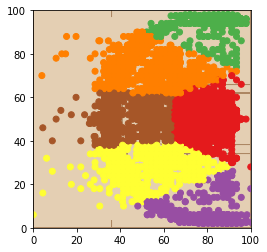

In [14]:
# Show the Natural Clusterings on the court with colors
X = np.zeros( (len(ShotsPD), 2) )
X[:, 0] = ShotsPD['left']
X[:, 1] = ShotsPD['top']
y_pred = KMeans(n_clusters=6, n_init=10, init='random', max_iter=300).fit_predict(X)

# Saves these locations to the dataframe
ShotsPD['LocationCluster'] = y_pred
ShotsPD.to_csv("location_dataframe_final.csv")

# Redistribute the left data to be on scale of 0-100 (to plot on court pic)
xNorm = 100*(ShotsPD['left'] - min(ShotsPD['left'])) / (max(ShotsPD['left']) - min(ShotsPD['left']))

plt.scatter(xNorm[:], X[:, 1], c=ShotsPD['LocationCluster'],  marker="o", cmap=seven_colors);
plt.imshow(img, zorder=0, extent=[0, 100, 0, 100.0])
plt.grid(False)
plt.show()

These clusters are interesting.  They naturally appear to match what we would identify as the key, the left and right corners, the wings, and the middle of the court. We added these groupings to our dataset

### We created shot charts for the team as a whole, and for each individual player

In [15]:
# unsupervised clustering can give different labels
# so read in already clustered data for consistency

ShotsPD = pd.read_csv("location_dataframe_final.csv")
ShotsPD = ShotsPD.replace("Royce O", "Royce O'Neale")

# Redistribute the left data to be on scale of 0-100
xNorm = 100*(ShotsPD['left'] - min(ShotsPD['left'])) / (max(ShotsPD['left']) - min(ShotsPD['left']))
ShotsPD['left'] = xNorm

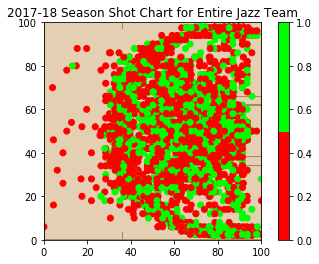

In [16]:
# Entire shots by Jazz by location, makes and misses
# greens are makes, reds are misses
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
plt.scatter(ShotsPD['left'],ShotsPD['top'],c=ShotsPD['made/missed'],cmap=cmap_bold)
plt.colorbar()
plt.imshow(img, zorder=0, extent=[0, 100, 0, 100.0])
plt.title('2017-18 Season Shot Chart for Entire Jazz Team')
plt.grid(False)
plt.show()

##### Individual players

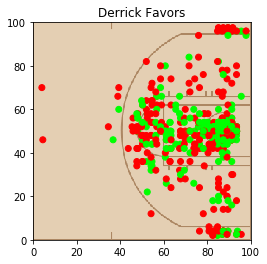

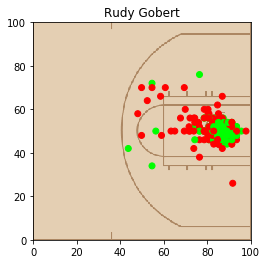

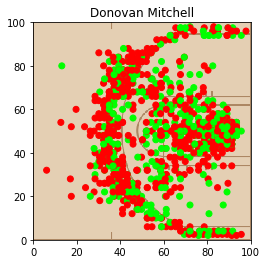

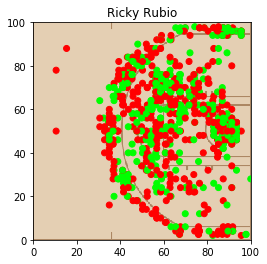

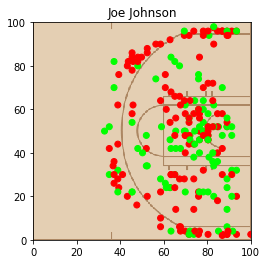

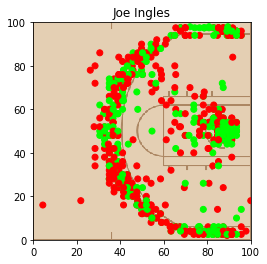

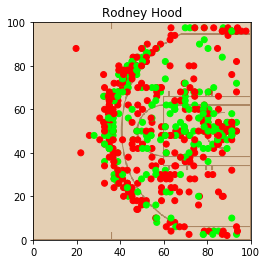

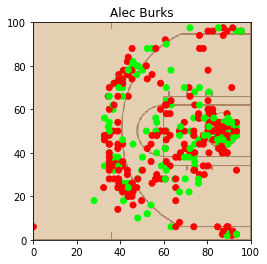

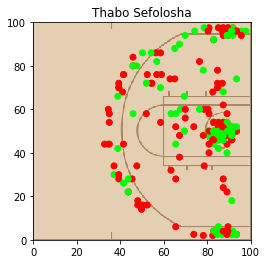

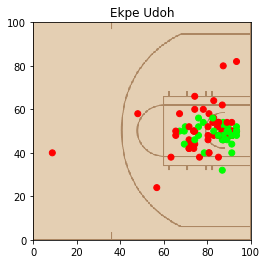

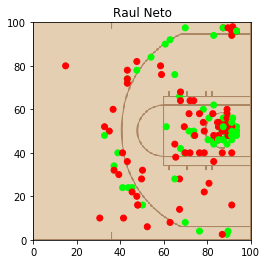

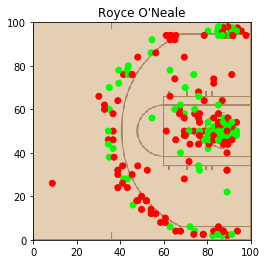

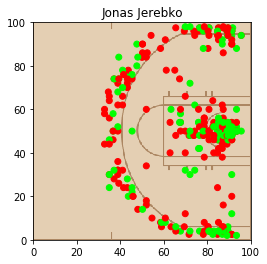

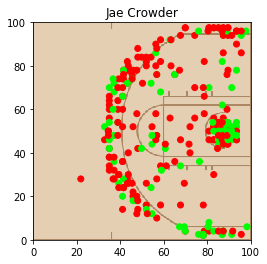

In [17]:
# shot chart for every player on the Jazz
# greens are makes, reds are misses
for shooter_name in ShotsPD['shooter_name'].unique():
    shooter_shots = ShotsPD[ShotsPD['shooter_name'] == shooter_name]
    plt.scatter(shooter_shots['left'], shooter_shots['top'], c=shooter_shots['made/missed'], cmap=cmap_bold)
    plt.title(str(shooter_name))
    plt.imshow(img, zorder=0, extent=[0, 100, 0, 100.0])
    plt.grid(False)
    plt.show()

#### We can use simple data frame masking and math to compute some simple statistics for individual players

In [18]:
mitchell_shots = ShotsPD[ShotsPD["shooter_name"]=="Donovan Mitchell"]
print('Number of Shots Mitchell has shot: ' + str(len(mitchell_shots)))
mitchell_makes = mitchell_shots[mitchell_shots["made/missed"]==1]
mitchell_misses = mitchell_shots[mitchell_shots["made/missed"]==0]
print('Number of Shots Mitchell has made: ' + str(len(mitchell_makes)))
print('Number of Shots Mitchell has missed: ' + str(len(mitchell_misses)))
print('Mitchell Field Goal Percentage: ' + str(len(mitchell_makes)/len(mitchell_shots)))  # Mitchell field goal shooting pct

Number of Shots Mitchell has shot: 1361
Number of Shots Mitchell has made: 595
Number of Shots Mitchell has missed: 766
Mitchell Field Goal Percentage: 0.4371785451873622


In [19]:
mitchell_threes = mitchell_shots[mitchell_shots["ThreePt"]==1]
mitchell_twos = mitchell_shots[mitchell_shots["ThreePt"]==0]
two_pt_pct = len(mitchell_twos[mitchell_twos["made/missed"]==1])/len(mitchell_twos)
three_pt_pct = len(mitchell_threes[mitchell_threes["made/missed"]==1])/len(mitchell_threes)
print("Mitchell's two point percentage is: " + str(round(two_pt_pct*100, 2)) + " %")
print("Mitchell's three point percentage is: " + str(round(three_pt_pct*100, 2)) + " %")

Mitchell's two point percentage is: 49.71 %
Mitchell's three point percentage is: 33.79 %


#### We try to get an idea of which regions have the highest expected value (for the team as a whole). We'll plot them later as well. This shows the expected values for 3 pointers and then two pointers

In [20]:
## Team Stats -- 3 Pointers
# 3 pointers
PercMadeDif3 = []
NumShots = []
NumMade = []
ExpectedValue3 =[]
AvLeft3 = []
AvTop3 =[]
PtVal = 3
for i in range(0,6):
    Location = ShotsPD[(ShotsPD['LocationCluster']==i) & (ShotsPD['ThreePt']==1)]
    NumShots.append(len(Location['made/missed']))
    NumMade.append(len(Location[Location['made/missed']==1]))
    if NumShots[i] > 1:
        PercMade = NumMade[i] / NumShots[i]
        PercMadeDif3.append(PercMade)
    else:
        PercMadeDif3.append(0)
    
    ExpectedValue3.append(PercMadeDif3[i]*PtVal)
    
    AvLeft3.append(np.mean(Location['left']))
    AvTop3.append(np.mean(Location['top']))
    
print('---- 3 Pointers ----')
print('Percentages')
print(PercMadeDif3)
print('---------------------')
print('Expected Values')
print(ExpectedValue3)

---- 3 Pointers ----
Percentages
[0, 0.4004474272930649, 0.35537190082644626, 0.3146551724137931, 0.3982102908277405, 0.35701906412478335]
---------------------
Expected Values
[0, 1.2013422818791946, 1.0661157024793388, 0.9439655172413792, 1.1946308724832215, 1.07105719237435]


In [21]:
## Team Stats -- 2 Pointers
# 2 pointers
PercMadeDif2 = []
NumShots = []
NumMade = []
ExpectedValue2 =[]
PtVal = 2
AvLeft2 = []
AvTop2 =[]

for i in range(0,6):
    Location = ShotsPD[(ShotsPD['LocationCluster']==i) & (ShotsPD['ThreePt']==0)]
    NumShots.append(len(Location['made/missed']))
    NumMade.append(len(Location[Location['made/missed']==1]))
    PercMade = NumMade[i] / NumShots[i]
    PercMadeDif2.append(PercMade)
    ExpectedValue2.append(PercMadeDif2[i]*PtVal)
    
    AvLeft2.append(np.mean(Location['left']))
    AvTop2.append(np.mean(Location['top']))
    
print('---- 2 Pointers ----')
print('Percentages')
print(PercMadeDif2)
print('---------------------')
print('Expected Values')
print(ExpectedValue2)

---- 2 Pointers ----
Percentages
[0.564875491480996, 0.4235294117647059, 0.44141689373297005, 0.34770114942528735, 0.35135135135135137, 0.39955357142857145]
---------------------
Expected Values
[1.129750982961992, 0.8470588235294118, 0.8828337874659401, 0.6954022988505747, 0.7027027027027027, 0.7991071428571429]


In [22]:
## Delete some parts mostly because the paint (key) cluster won't have a 3, only a 2.
xx = np.isnan(AvLeft3)
DeleteVar = []
for i in range(0, len(AvLeft3)):
    if  xx[i] == True:
        DeleteVar = i
DeleteVar
del AvLeft3[DeleteVar] 
del AvTop3[DeleteVar] 

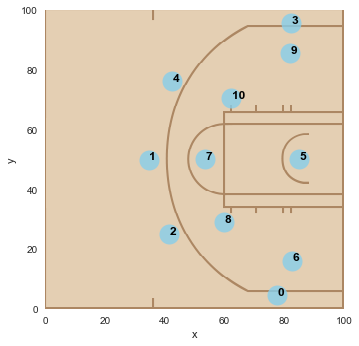

In [23]:
# Show where each cluster is located on the court (the means!)
import seaborn as sns

df = pd.DataFrame({
'x': AvLeft3 + AvLeft2,
'y': AvTop3 + AvTop2,
'group': ['0','1', '2','3','4','5','6','7','8','9','10']
})
 
p1=sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
for line in range(0,df.shape[0]):
    p1.text(df.x[line]+0.2, df.y[line], df.group[line], horizontalalignment='left', size='medium', 
            color='black', weight='semibold')
 
plt.imshow(img, zorder=0, extent=[0, 100, 0, 100.0])
plt.grid(False)
plt.show()



In [24]:
## Delete the 3's for the parents of cluster 5
for i in range(0,len(ExpectedValue3)):
    if ExpectedValue3[i] == 0:
        Extra = i
del ExpectedValue3[Extra]

# Create expected values and round it for simplicity
ExpectedValue = ExpectedValue3 + ExpectedValue2
ExpectedValueRound = np.round_(ExpectedValue, decimals=2) 

## Analysis

Plot the expected values for the team

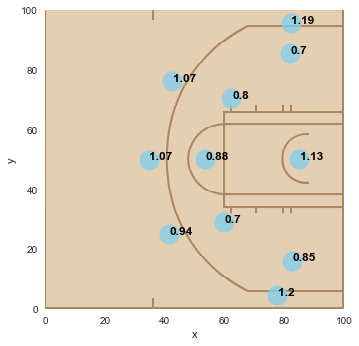

In [25]:
## Team chart with expected values
ExpectedValue = ExpectedValue3 + ExpectedValue2
df = pd.DataFrame({
'x': AvLeft3 + AvLeft2,
'y': AvTop3 + AvTop2,
'group': [str(ExpectedValueRound[0]),str(ExpectedValueRound[1]),str(ExpectedValueRound[2]),
          str(ExpectedValueRound[3]),str(ExpectedValueRound[4]),str(ExpectedValueRound[5]),
          str(ExpectedValueRound[6]),str(ExpectedValueRound[7]),str(ExpectedValueRound[8]),
          str(ExpectedValueRound[9]),str(ExpectedValueRound[10])]
})
 
p1=sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
for line in range(0,df.shape[0]):
    p1.text(df.x[line]+0.2, df.y[line], df.group[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
 
plt.imshow(img, zorder=0, extent=[0, 100, 0, 100.0])
plt.grid(False)
sns.plt.show()

Heat map for the team with color scale

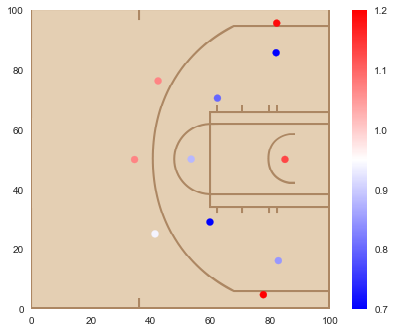

In [26]:
x = AvLeft3 + AvLeft2
y = AvTop3 + AvTop2
B = ExpectedValueRound
low = np.min(B)
high = np.max(B)
cs = plt.scatter(x,y,c=B,cmap=plt.cm.bwr,vmin=low,vmax=high)

plt.colorbar(cs)
plt.imshow(img, zorder=0, extent=[0, 100, 0, 100.0])
plt.grid(False)
plt.show()
# red is hot--high expected value.  blue is cool--low expected value

#### As we can see, corner threes and twos in the key are the most efficient shots for the Jazz team overall. The longer jumper two's are the worst shot the Jazz can shoot as a team. Hence, from this plot we can take it that shooting a two pointer isn't really worth it, unless it is inside the paint. 

Using masking and loops with added logic, we are able to look at all the expected values on the court for each player. We will also print out the values and player name

---------------------------------------------------------------
Alec Burks
---------------------
---- 3 Pointers ----
Percentages
[0, 0.3888888888888889, 0.34615384615384615, 0.225, 0.375, 0.38235294117647056]
---------------------
Expected Values
[0, 1.1666666666666667, 1.0384615384615383, 0.675, 1.125, 1.1470588235294117]
---- 2 Pointers ----
Percentages
[0.4816753926701571, 0, 0.38461538461538464, 0.358974358974359, 0.0, 0.47619047619047616]
---------------------
Expected Values
[0.9633507853403142, 0, 0.7692307692307693, 0.717948717948718, 0.0, 0.9523809523809523]


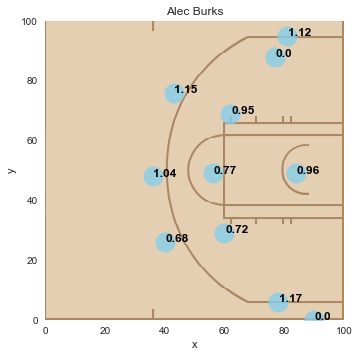

---------------------------------------------------------------
Derrick Favors
---------------------
---- 3 Pointers ----
Percentages
[0, 0.26666666666666666, 0.3333333333333333, 0, 0.19230769230769232, 0.0]
---------------------
Expected Values
[0, 0.8, 1.0, 0, 0.576923076923077, 0.0]
---- 2 Pointers ----
Percentages
[0.6680584551148225, 0.3333333333333333, 0.4473684210526316, 0.3793103448275862, 0.3333333333333333, 0.25806451612903225]
---------------------
Expected Values
[1.336116910229645, 0.6666666666666666, 0.8947368421052632, 0.7586206896551724, 0.6666666666666666, 0.5161290322580645]


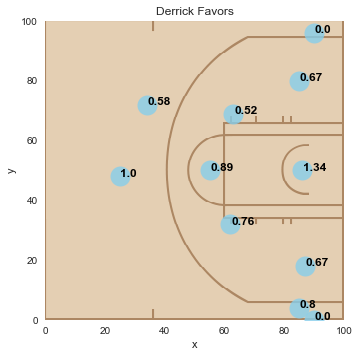

---------------------------------------------------------------
Donovan Mitchell
---------------------
---- 3 Pointers ----
Percentages
[0, 0.36764705882352944, 0.35454545454545455, 0.3115942028985507, 0.5434782608695652, 0.2733333333333333]
---------------------
Expected Values
[0, 1.1029411764705883, 1.0636363636363637, 0.9347826086956521, 1.6304347826086956, 0.82]
---- 2 Pointers ----
Percentages
[0.5358931552587646, 0.7, 0.4, 0.32941176470588235, 0.42857142857142855, 0.44871794871794873]
---------------------
Expected Values
[1.0717863105175292, 1.4, 0.8, 0.6588235294117647, 0.8571428571428571, 0.8974358974358975]


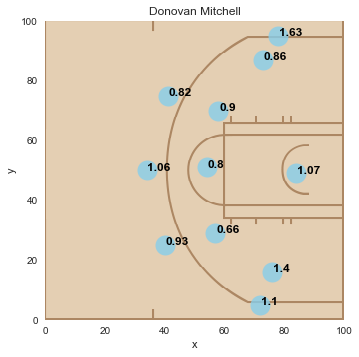

---------------------------------------------------------------
Ekpe Udoh
---------------------
---- 3 Pointers ----
Percentages
[0, 0, 0, 0, 0, 0]
---------------------
Expected Values
[0, 0, 0, 0, 0, 0]
---- 2 Pointers ----
Percentages
[0.5357142857142857, 0, 0, 0.0, 0.0, 0]
---------------------
Expected Values
[1.0714285714285714, 0, 0, 0.0, 0.0, 0]


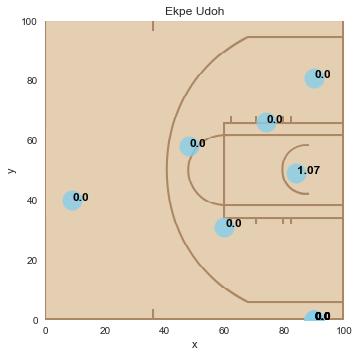

---------------------------------------------------------------
Jae Crowder
---------------------
---- 3 Pointers ----
Percentages
[0, 0.5833333333333334, 0.3, 0.2727272727272727, 0.21875, 0.2777777777777778]
---------------------
Expected Values
[0, 1.75, 0.8999999999999999, 0.8181818181818181, 0.65625, 0.8333333333333334]
---- 2 Pointers ----
Percentages
[0.5617977528089888, 0.5, 0.3333333333333333, 0.21428571428571427, 0.2222222222222222, 0.3125]
---------------------
Expected Values
[1.1235955056179776, 1.0, 0.6666666666666666, 0.42857142857142855, 0.4444444444444444, 0.625]


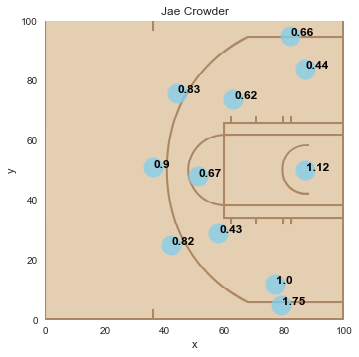

---------------------------------------------------------------
Joe Ingles
---------------------
---- 3 Pointers ----
Percentages
[0, 0.46296296296296297, 0.45614035087719296, 0.3655913978494624, 0.4939759036144578, 0.4387755102040816]
---------------------
Expected Values
[0, 1.3888888888888888, 1.3684210526315788, 1.096774193548387, 1.4819277108433735, 1.316326530612245]
---- 2 Pointers ----
Percentages
[0.5621890547263682, 0.5, 0.4166666666666667, 0.3157894736842105, 0.25, 0.3333333333333333]
---------------------
Expected Values
[1.1243781094527363, 1.0, 0.8333333333333334, 0.631578947368421, 0.5, 0.6666666666666666]


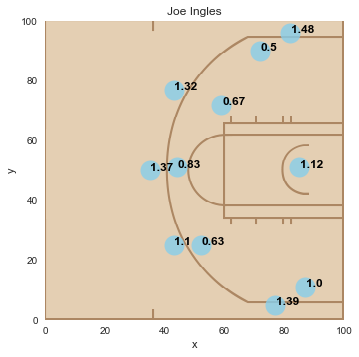

---------------------------------------------------------------
Joe Johnson
---------------------
---- 3 Pointers ----
Percentages
[0, 0.3076923076923077, 0.4, 0.35714285714285715, 0.21739130434782608, 0.14285714285714285]
---------------------
Expected Values
[0, 0.9230769230769231, 1.2000000000000002, 1.0714285714285714, 0.6521739130434783, 0.42857142857142855]
---- 2 Pointers ----
Percentages
[0.56, 0.5, 0.6363636363636364, 0.4583333333333333, 0.0, 0.38095238095238093]
---------------------
Expected Values
[1.12, 1.0, 1.2727272727272727, 0.9166666666666666, 0.0, 0.7619047619047619]


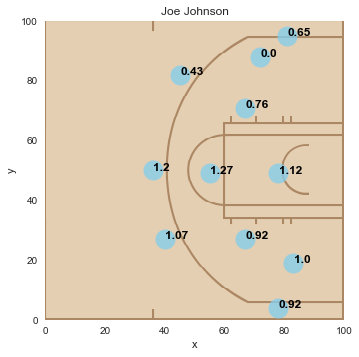

---------------------------------------------------------------
Jonas Jerebko
---------------------
---- 3 Pointers ----
Percentages
[0, 0.4883720930232558, 0.2857142857142857, 0.3333333333333333, 0.4772727272727273, 0.3548387096774194]
---------------------
Expected Values
[0, 1.4651162790697674, 0.8571428571428571, 1.0, 1.4318181818181819, 1.064516129032258]
---- 2 Pointers ----
Percentages
[0.5424836601307189, 0.14285714285714285, 0.4, 0.75, 0.36363636363636365, 0.2]
---------------------
Expected Values
[1.0849673202614378, 0.2857142857142857, 0.8, 1.5, 0.7272727272727273, 0.4]


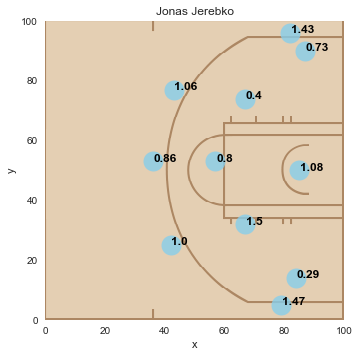

---------------------------------------------------------------
Raul Neto
---------------------
---- 3 Pointers ----
Percentages
[0, 0.5, 0.2, 0.38461538461538464, 0.46153846153846156, 0.375]
---------------------
Expected Values
[0, 1.5, 0.6000000000000001, 1.153846153846154, 1.3846153846153846, 1.125]
---- 2 Pointers ----
Percentages
[0.5294117647058824, 0.25, 1.0, 0.14285714285714285, 0, 0.25]
---------------------
Expected Values
[1.0588235294117647, 0.5, 2.0, 0.2857142857142857, 0, 0.5]


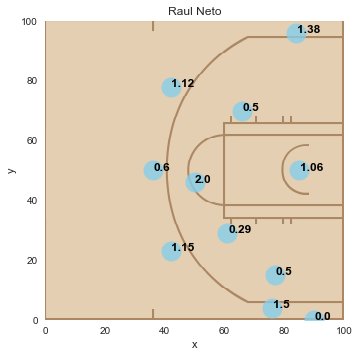

---------------------------------------------------------------
Ricky Rubio
---------------------
---- 3 Pointers ----
Percentages
[0, 0.2619047619047619, 0.22727272727272727, 0.42857142857142855, 0.4090909090909091, 0.38823529411764707]
---------------------
Expected Values
[0, 0.7857142857142858, 0.6818181818181818, 1.2857142857142856, 1.2272727272727273, 1.1647058823529413]
---- 2 Pointers ----
Percentages
[0.47107438016528924, 0.45454545454545453, 0.4883720930232558, 0.41935483870967744, 0.4444444444444444, 0.4068965517241379]
---------------------
Expected Values
[0.9421487603305785, 0.9090909090909091, 0.9767441860465116, 0.8387096774193549, 0.8888888888888888, 0.8137931034482758]


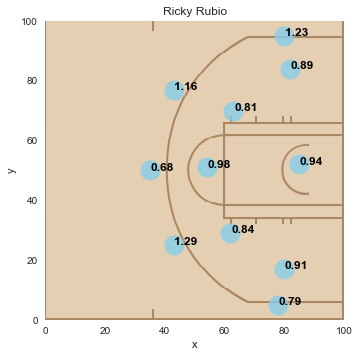

---------------------------------------------------------------
Rodney Hood
---------------------
---- 3 Pointers ----
Percentages
[0, 0.4074074074074074, 0.4098360655737705, 0.27906976744186046, 0.28125, 0.43956043956043955]
---------------------
Expected Values
[0, 1.222222222222222, 1.2295081967213115, 0.8372093023255813, 0.84375, 1.3186813186813187]
---- 2 Pointers ----
Percentages
[0.5289855072463768, 0.375, 0.4444444444444444, 0.2653061224489796, 0.5, 0.48]
---------------------
Expected Values
[1.0579710144927537, 0.75, 0.8888888888888888, 0.5306122448979592, 1.0, 0.96]


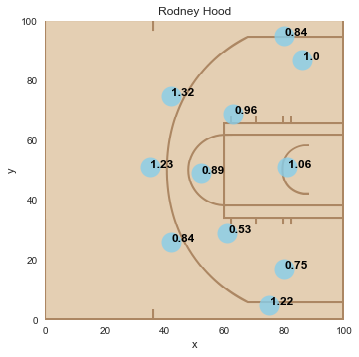

---------------------------------------------------------------
Royce O'Neale
---------------------
---- 3 Pointers ----
Percentages
[0, 0.34285714285714286, 0.36363636363636365, 0.16666666666666666, 0.3684210526315789, 0.4166666666666667]
---------------------
Expected Values
[0, 1.0285714285714285, 1.0909090909090908, 0.5, 1.1052631578947367, 1.25]
---- 2 Pointers ----
Percentages
[0.4726027397260274, 0, 0.6666666666666666, 0.42857142857142855, 0.0, 0.5833333333333334]
---------------------
Expected Values
[0.9452054794520548, 0, 1.3333333333333333, 0.8571428571428571, 0.0, 1.1666666666666667]


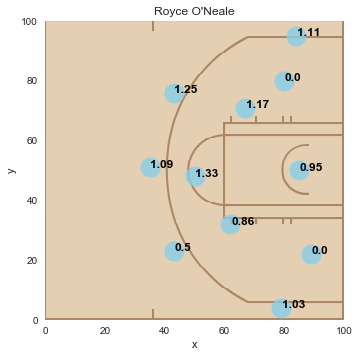

---------------------------------------------------------------
Rudy Gobert
---------------------
---- 3 Pointers ----
Percentages
[0, 0, 0, 0, 0, 0]
---------------------
Expected Values
[0, 0, 0, 0, 0, 0]
---- 2 Pointers ----
Percentages
[0.636150234741784, 0, 0.3333333333333333, 0, 0, 0.25]
---------------------
Expected Values
[1.272300469483568, 0, 0.6666666666666666, 0, 0, 0.5]


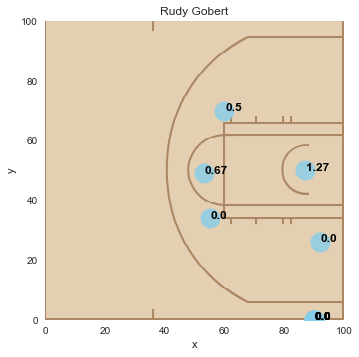

---------------------------------------------------------------
Thabo Sefolosha
---------------------
---- 3 Pointers ----
Percentages
[0, 0.45, 0.3333333333333333, 0.23076923076923078, 0.42857142857142855, 0.35714285714285715]
---------------------
Expected Values
[0, 1.35, 1.0, 0.6923076923076923, 1.2857142857142856, 1.0714285714285714]
---- 2 Pointers ----
Percentages
[0.6120689655172413, 0.25, 0.3333333333333333, 0.16666666666666666, 0.625, 0.3684210526315789]
---------------------
Expected Values
[1.2241379310344827, 0.5, 0.6666666666666666, 0.3333333333333333, 1.25, 0.7368421052631579]


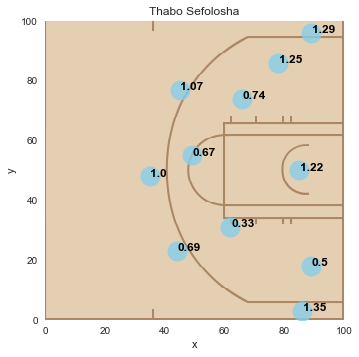

In [27]:
# 3 pointers
PlayerIDs = np.unique(ShotsPD['shooter'])
PlayerNames = np.unique(ShotsPD['shooter_name'])
NumOPlayers = len(PlayerNames)
for Name in range(0,NumOPlayers):
    PercMadeDif3 = []
    NumShots = []
    NumMade = []
    ExpectedValue3 =[]
    AvLeft3 = []
    AvTop3 =[]
    PtVal3 = 3
    PtVal2 = 2
    PercMadeDif2 = []
    NumShots3 = []
    NumShots2 = []
    NumMade3 = []
    NumMade2 = []
    ExpectedValue2 =[]
    ExpectedValueRound = []
 
    AvLeft2 = []
    AvTop2 =[]
    
    for i in range(0,6):
        Location = ShotsPD[(ShotsPD['LocationCluster']==i) & (ShotsPD['ThreePt']==1) 
                           & ( ShotsPD['shooter_name'] == PlayerNames[Name])]     
        NumShots3.append(len(Location['made/missed']))
        NumMade3.append(len(Location[Location['made/missed']==1]))
        PercMade3 = 0
        if NumShots3[i] > 1:
            PercMade3 = NumMade3[i] / NumShots3[i]
            PercMadeDif3.append(PercMade3)
        else:
            PercMadeDif3.append(0)
    
        ExpectedValue3.append(PercMadeDif3[i]*PtVal3)
    
        AvLeft3.append(np.mean(Location['left']))
        AvTop3.append(np.mean(Location['top']))
        
        
        
    
        
        Location = ShotsPD[(ShotsPD['LocationCluster']==i) & (ShotsPD['ThreePt']==0) 
                           & ( ShotsPD['shooter_name'] == PlayerNames[Name])]
        NumShots2.append(len(Location['made/missed']))
        NumMade2.append(len(Location[Location['made/missed']==1]))
        PercMade2 = 0
        if NumShots2[i] > 1:
                PercMade2 = NumMade2[i] / NumShots2[i]
                PercMadeDif2.append(PercMade2)
        else:
                PercMadeDif2.append(0)
        ExpectedValue2.append(PercMadeDif2[i]*PtVal2)
    
        AvLeft2.append(np.mean(Location['left']))
        AvTop2.append(np.mean(Location['top']))
        
    print('---------------------------------------------------------------')
    print(PlayerNames[Name])
    print('---------------------')
    print('---- 3 Pointers ----')
    print('Percentages')
    print(PercMadeDif3)
    print('---------------------')
    print('Expected Values')
    print(ExpectedValue3)
    

    
    print('---- 2 Pointers ----')
    print('Percentages')
    print(PercMadeDif2)
    print('---------------------')
    print('Expected Values')
    print(ExpectedValue2)
    
    for mm in range(0,len(ExpectedValue3)):
        if ExpectedValue3[mm] == 0:
            Extra = mm
    del ExpectedValue3[Extra]
    
    xx = np.isnan(AvLeft3)
    for mm in range(0, len(AvLeft3)):
        if  xx[mm] == True:
            DeleteVar = mm
    
    del AvLeft3[DeleteVar] 
    del AvTop3[DeleteVar]
    
    ExpectedValue = ExpectedValue3 + ExpectedValue2
    ExpectedValueRound = np.round_(ExpectedValue, decimals=2) 
    
    AvLefts = AvLeft3 + AvLeft2
    AvTops = AvTop3 + AvTop2
    
    for u in range(0,len(AvLefts)):
        if math.isnan(AvLefts[u]):
            AvLefts[u]=90
        if math.isnan(AvTops[u]):
            AvTops[u]= 0
        
    
    x = np.round(AvLefts,decimals=0)
    y = np.round(AvTops,decimals=0)
    valz = [str(ExpectedValueRound[0]),str(ExpectedValueRound[1]),str(ExpectedValueRound[2]),
            str(ExpectedValueRound[3]),str(ExpectedValueRound[4]),str(ExpectedValueRound[5]),
            str(ExpectedValueRound[6]),str(ExpectedValueRound[7]),str(ExpectedValueRound[8]),
            str(ExpectedValueRound[9]),str(ExpectedValueRound[10])]
    df = pd.DataFrame({
    'x': x,
    'y': y,
    'group': valz
    })
 
    p1=sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
    for line in range(0,df.shape[0]):
        p1.text(df.x[line]+0.2, df.y[line], df.group[line], horizontalalignment='left', 
                size='medium', color='black', weight='semibold')
 
    plt.title(PlayerNames[Name])
    plt.imshow(img, zorder=0, extent=[0, 100, 0, 100.0])
    plt.grid(False)
    plt.show()
    

## Statistical Significance

At low sampling rates, a given shot could have a high expected value purely by chance.  For example, 25% of the time, a 50% shooter will make two shots in a row.  If those two shots are the only sample we have, we might conclude that the shooter is a 100% shooter.  For this reason, it is important to determine if results are statistically significant, or if they most likely occured by chance.  Hypothesis testing is a good way to measure statistical significance.  It involves formulating a null hypothesis that you would like to disprove, calculating the probability of a given result occurring if you were to assume that the null hypothesis is true, and rejecting the null hypothesis if that probability is sufficiently low.

### Hypothesis Testing:

Player p-test:
- Take as the null hypothesis that the shooting percentage for a given shot is less than or equal to the average percentage for that player for threes or twos.

Team p-test:
- Take as the null hypothesis that the shooting percentage for a given shot is less than or equal to the average percentage for the whole team for threes or twos.

Location p-test:
- Take as the null hypothesis that the shooting percentage for a given shot is less than or equal to the average percentage for the whole team from that location.

In [28]:
shots_array = np.array([["shooter", "three", "cluster", 'num_shots', "num_makes", "pct", "expectedval", 
                         "Player_p", "Team_p", "Location_p"]])
threemask = ShotsPD["ThreePt"] == 1
twomask = ShotsPD["ThreePt"] == 0
threePD = ShotsPD[threemask]
twoPD = ShotsPD[twomask]

for shooter in threePD["shooter_name"].unique():
    mask = threePD["shooter_name"] == shooter
    ShooterShots = threePD[mask]
    for cluster in ShooterShots["LocationCluster"].unique():
        mask2 = ShooterShots["LocationCluster"] == cluster
        ClusterShots = ShooterShots[mask2]
        num_shots =  len(ClusterShots)
        mask_made =ClusterShots["made/missed"] == 1
        num_makes = len(ClusterShots[mask_made])
        pct = num_makes/num_shots
        expectedval = pct*3
        # player p-value
        avg_pct = len(ShooterShots[ShooterShots["made/missed"]==1])/len(ShooterShots)  
        # total 3 pt avg for this player
        mu = num_shots*avg_pct  # mean number of makes for this cluster assuming average shooting
        sigma = sc.sqrt(mu*(1-avg_pct))  # standard deviation?
        player_p = 1-norm.cdf(num_makes, loc=mu, scale=sigma)
        # team p-value
        avg_pct = len(threePD[threePD["made/missed"]==1])/len(threePD)  # total 3 pt avg for the team
        mu = num_shots*avg_pct
        sigma = sc.sqrt(mu*(1-avg_pct))
        team_p = 1-norm.cdf(num_makes, loc=mu, scale=sigma)
        # location p-value
        teamClusterPD = threePD[threePD["LocationCluster"] == cluster]
        avg_pct = len(teamClusterPD[teamClusterPD["made/missed"]==1])/len(teamClusterPD)  
        # team 3 pt avg from this cluster
        mu = num_shots*avg_pct
        sigma = sc.sqrt(mu*(1-avg_pct))
        location_p = 1-norm.cdf(num_makes, loc=mu, scale=sigma)
        
        shots_array = np.append(shots_array, [[shooter, 1, cluster, num_shots, 
                                               num_makes, pct, expectedval, player_p, 
                                               team_p, location_p]], axis=0)
        
for shooter in twoPD["shooter_name"].unique():
    mask = twoPD["shooter_name"] == shooter
    ShooterShots = twoPD[mask]
    for cluster in ShooterShots["LocationCluster"].unique():
        mask2 = ShooterShots["LocationCluster"] == cluster
        ClusterShots = ShooterShots[mask2]
        num_shots =  len(ClusterShots)
        mask_made =ClusterShots["made/missed"] == 1
        num_makes = len(ClusterShots[mask_made])
        pct = num_makes/num_shots
        expectedval = pct*2
        
        avg_pct = len(ShooterShots[ShooterShots["made/missed"]==1])/len(ShooterShots)  
        #total 3 pt avg for this player
        mu = num_shots*avg_pct  # mean number of makes for this cluster
        sigma = sc.sqrt(mu*(1-avg_pct))  # standard deviation?
        player_p = 1-norm.cdf(num_makes, loc=mu, scale=sigma)
        # team p-value
        avg_pct = len(twoPD[twoPD["made/missed"]==1])/len(twoPD)  # total 3 pt avg for the team
        mu = num_shots*avg_pct
        sigma = sc.sqrt(mu*(1-avg_pct))
        team_p = 1-norm.cdf(num_makes, loc=mu, scale=sigma)
        # location p-value
        teamClusterPD = twoPD[twoPD["LocationCluster"] == cluster]
        avg_pct = len(teamClusterPD[teamClusterPD["made/missed"]==1])/len(teamClusterPD)  
        # team 3 pt avg from this cluster
        mu = num_shots*avg_pct
        sigma = sc.sqrt(mu*(1-avg_pct))
        location_p = 1-norm.cdf(num_makes, loc=mu, scale=sigma)
        
        shots_array = np.append(shots_array, [[shooter, 0, cluster, num_shots, 
                                               num_makes, pct, expectedval, player_p, 
                                               team_p, location_p]], axis=0)

/Users/averysmith/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1732: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [29]:
NewLocationPD = pd.DataFrame(data=shots_array[1:],
                             columns=shots_array[0])

In [30]:
NewLocationPD["three"] = NewLocationPD["three"].map(int)
NewLocationPD["cluster"] = NewLocationPD["cluster"].map(int)
NewLocationPD["num_shots"] = NewLocationPD["num_shots"].map(int)
NewLocationPD["num_makes"] = NewLocationPD["num_makes"].map(int)
NewLocationPD["pct"] = NewLocationPD["pct"].map(float)
NewLocationPD["expectedval"] = NewLocationPD["expectedval"].map(float)
NewLocationPD["Player_p"] = NewLocationPD["Player_p"].map(float)
NewLocationPD["Team_p"] = NewLocationPD["Team_p"].map(float)
NewLocationPD["Location_p"] = NewLocationPD["Location_p"].map(float)
print(NewLocationPD.dtypes, '\n')

shooter         object
three            int64
cluster          int64
num_shots        int64
num_makes        int64
pct            float64
expectedval    float64
Player_p       float64
Team_p         float64
Location_p     float64
dtype: object 



In [31]:
# print the 40 best expected value shots()
NewLocationPD.sort_values(by=["expectedval"], ascending=False).head(40)

,shooter,three,cluster,num_shots,num_makes,pct,expectedval,Player_p,Team_p,Location_p
120,Raul Neto,0,2,2,2,1.000000,2.000000,0.070967,8.451872e-02,0.055820
68,Rudy Gobert,0,3,1,1,1.000000,2.000000,0.219013,1.654043e-01,0.085393
127,Royce O'Neale,0,1,1,1,1.000000,2.000000,0.148750,1.654043e-01,0.121673
56,Jae Crowder,1,1,24,14,0.583333,1.750000,0.002547,1.302116e-02,0.033736
15,Donovan Mitchell,1,4,46,25,0.543478,1.630435,0.001599,5.874529e-03,0.022075
43,Raul Neto,1,1,6,3,0.500000,1.500000,0.308538,2.455023e-01,0.309358
133,Jonas Jerebko,0,3,4,3,0.750000,1.500000,0.166598,1.724358e-01,0.045564
2,Joe Ingles,1,4,83,41,0.493976,1.481928,0.169766,7.192182e-03,0.037354
53,Jonas Jerebko,1,1,43,21,0.488372,1.465116,0.170106,4.596406e-02,0.119662
51,Jonas Jerebko,1,4,44,21,0.477273,1.431818,0.207412,6.035049e-02,0.142014


In [32]:
# identify the mean location for each of the six clusters identified through kMeans
# (ignoring two and three point differences)
left_coordinates = np.array([])
top_coordinates = np.array([])
clusters = np.arange(0, 6)
for cluster in clusters:
    cluster_mask = ShotsPD['LocationCluster'] == cluster
    cluster_df = ShotsPD[cluster_mask]
    left_coord = cluster_df["left"].mean()
    top_coord = cluster_df["top"].mean()
    left_coordinates = np.append(left_coordinates, left_coord)
    top_coordinates = np.append(top_coordinates, top_coord)

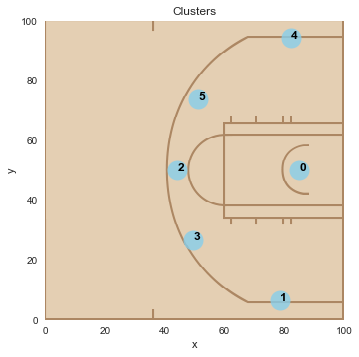

In [33]:
# plot the mean location of each cluster on the court for reference purposes
import seaborn as sns

df = pd.DataFrame({
'x': left_coordinates,
'y': top_coordinates,
'group': clusters
})
 
p1=sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
for line in range(0,df.shape[0]):
    p1.text(df.x[line]+0.2, df.y[line], df.group[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')

plt.title('Clusters')
plt.imshow(img, zorder=0, extent=[0, 100, 0, 100.0])
plt.grid(False)
plt.show()

We choose a threshold for significance of p < .05 in order to reject the null hypothesis.

For each p-test we used, we filter the results for only the statistically significant shots.

The way to interpret these p-values is: if that location was not better than average (for the player or team as a whole), then the p-value represents the probability that the player would still, by coincidence, shoot as well from that location as they did.

#### Player p-test

In [34]:
statistically_significant_mask = NewLocationPD["Player_p"] < .05
SignificantPD = NewLocationPD[statistically_significant_mask]
SignificantPD.sort_values(by=["expectedval"], ascending=False)

,shooter,three,cluster,num_shots,num_makes,pct,expectedval,Player_p,Team_p,Location_p
56,Jae Crowder,1,1,24,14,0.583333,1.750000,0.002547,1.302116e-02,0.033736
15,Donovan Mitchell,1,4,46,25,0.543478,1.630435,0.001599,5.874529e-03,0.022075
60,Derrick Favors,0,0,479,320,0.668058,1.336117,0.000679,7.471357e-12,0.000003
135,Jae Crowder,0,0,89,50,0.561798,1.123596,0.019917,1.832057e-01,0.523351
71,Donovan Mitchell,0,0,599,321,0.535893,1.071786,0.028644,1.412531e-01,0.923749


This indicates that Jae Crowder shoots significantly better from the right corner than he does from any other three point location, and Donovan Mitchell shoots significantly better from the left corner than he does from any other three point location.  This information could help coaches modify the offense so that Crowder and Mitchell spend more time on the right and left side respectively.

Unsurprisingly, we found that Derrick Favors, Jae Crowder, and Donovan Mitchell all shoot better from the post than they do from any other two-point position.  That is unsurprising because the post is much closer to the basket than other locations, and is expected to have a better shooting percentage.

In [35]:
statistically_significant_mask = NewLocationPD["Team_p"] < .05
TeamSignificantPD = NewLocationPD[statistically_significant_mask]
TeamSignificantPD.sort_values(by=["expectedval"], ascending=False)

,shooter,three,cluster,num_shots,num_makes,pct,expectedval,Player_p,Team_p,Location_p
56,Jae Crowder,1,1,24,14,0.583333,1.750000,0.002547,1.302116e-02,0.033736
15,Donovan Mitchell,1,4,46,25,0.543478,1.630435,0.001599,5.874529e-03,0.022075
2,Joe Ingles,1,4,83,41,0.493976,1.481928,0.169766,7.192182e-03,0.037354
53,Jonas Jerebko,1,1,43,21,0.488372,1.465116,0.170106,4.596406e-02,0.119662
1,Joe Ingles,1,1,108,50,0.462963,1.388889,0.329792,1.690596e-02,0.092435
60,Derrick Favors,0,0,479,320,0.668058,1.336117,0.000679,7.471357e-12,0.000003
66,Rudy Gobert,0,0,426,271,0.636150,1.272300,0.308772,2.249937e-07,0.001502
100,Thabo Sefolosha,0,0,116,71,0.612069,1.224138,0.080125,1.723821e-02,0.152624


This indicates that the three point shots noted above for Jae Crowder and Donovan Mitchell are also significantly better than the team average for three point shots.  Joe Ingles (an excellent three point shooter) also shoots significantly better from both corners than the team three point average (although he does not shoot significantly better from the corners than he does from the other three point spots because his overall three point shooting percentage is so high).  Jonas Jerebko also shoots significantly better from the right corner than the team average for three pointers.  

For two pointers, we now find that Derrick Favors, Rudy Gobert, and Thabo Sefolosha all shoot significantly better from the post than the team average for two pointers.  The p-values for Derrick Favors and Rudy Gobert are extremely small, partially due to the large number of shots taken by both players from that location (>400).  Rudy Gobert likely didn't show up on the previous list because such a high percentage of his shots are taken from the post that his two point percentage is effectively the same as his shooting percentage from the post.

In [36]:
statistically_significant_mask = NewLocationPD["Location_p"] < .05
LocationSignificantPD = NewLocationPD[statistically_significant_mask]
LocationSignificantPD.sort_values(by=["expectedval"], ascending=False)

,shooter,three,cluster,num_shots,num_makes,pct,expectedval,Player_p,Team_p,Location_p
56,Jae Crowder,1,1,24,14,0.583333,1.750000,0.002547,1.302116e-02,0.033736
15,Donovan Mitchell,1,4,46,25,0.543478,1.630435,0.001599,5.874529e-03,0.022075
133,Jonas Jerebko,0,3,4,3,0.750000,1.500000,0.166598,1.724358e-01,0.045564
2,Joe Ingles,1,4,83,41,0.493976,1.481928,0.169766,7.192182e-03,0.037354
76,Donovan Mitchell,0,1,10,7,0.700000,1.400000,0.099649,1.195645e-01,0.038416
60,Derrick Favors,0,0,479,320,0.668058,1.336117,0.000679,7.471357e-12,0.000003
3,Joe Ingles,1,5,98,43,0.438776,1.316327,0.524938,6.372811e-02,0.045587
66,Rudy Gobert,0,0,426,271,0.636150,1.272300,0.308772,2.249937e-07,0.001502


The last hypothesis tested was whether certain players shot much better than the team average for that specific location.  Apart from identifying some of the same shots as above, this test would be expected to ffind some players who shoot exceptionally well from more difficult spots.  

Jonas Jerebko shooting two pointers from the right wing, Donovan Mitchell shooting two pointers from the right corner, Joe Ingles shooting from the top of the three-point arc, and Rodney Hood shooting three pointers from the left wing would all appear to fit in this category, although each falls just at the limits of statistical significance (.4 < p < .5).

**Conclusions**
This information can help coaches and decision-makers design offensive sets and plays, and can help players with shot-selection.  
For example, for the first p-test, we would advise Donovan Mitchell to take more three point shots from the left corner, and Jae Crowder to take more from the right corner.  Coaches could design their offense so both players spend more time on those sides.  We would also advise Donovan Mitchell to drive all the way to the basket when taking a two-point shot.  

For the second p-test, we would advise the coaches to develop their offense to maximize corner threes by Crowder, Mitchell, Ingles, and Jerebko, and post shots by Favors and Gobert.  

## Some additional Analysis

### Home and Away Differences
- We wanted to explore how the expected values for each player differ in home games vs away games. Once agian, we used simple masking to compare how players shoot at home and away.

---------------------------------------------------------------
Alec Burks
---------------------
---- 3 Pointers ----
Percentages
[0, 0.2222222222222222, 0.4, 0.125, 0.25, 0.2777777777777778]
---------------------
Expected Values
[0, 0.6666666666666666, 1.2000000000000002, 0.375, 0.75, 0.8333333333333334]
---- 2 Pointers ----
Percentages
[0.40540540540540543, 0, 0.42857142857142855, 0.4444444444444444, 0, 0.2]
---------------------
Expected Values
[0.8108108108108109, 0, 0.8571428571428571, 0.8888888888888888, 0, 0.4]


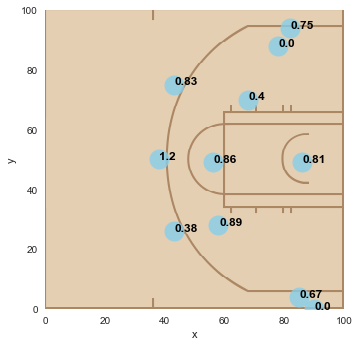

---------------------------------------------------------------
Derrick Favors
---------------------
---- 3 Pointers ----
Percentages
[0, 0.38461538461538464, 0.5, 0, 0.2, 0.0]
---------------------
Expected Values
[0, 1.153846153846154, 1.5, 0, 0.6000000000000001, 0.0]
---- 2 Pointers ----
Percentages
[0.6329113924050633, 0.2857142857142857, 0.42857142857142855, 0.46153846153846156, 0.14285714285714285, 0.2857142857142857]
---------------------
Expected Values
[1.2658227848101267, 0.5714285714285714, 0.8571428571428571, 0.9230769230769231, 0.2857142857142857, 0.5714285714285714]


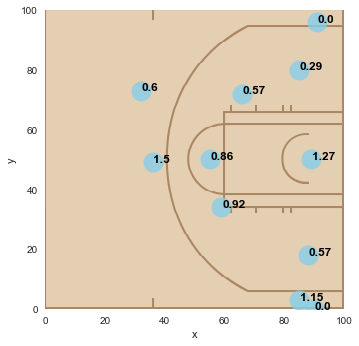

---------------------------------------------------------------
Donovan Mitchell
---------------------
---- 3 Pointers ----
Percentages
[0, 0.3793103448275862, 0.38181818181818183, 0.35526315789473684, 0.45, 0.2878787878787879]
---------------------
Expected Values
[0, 1.1379310344827585, 1.1454545454545455, 1.0657894736842106, 1.35, 0.8636363636363638]
---- 2 Pointers ----
Percentages
[0.5144694533762058, 0.5, 0.4444444444444444, 0.36585365853658536, 0.5, 0.3888888888888889]
---------------------
Expected Values
[1.0289389067524115, 1.0, 0.8888888888888888, 0.7317073170731707, 1.0, 0.7777777777777778]


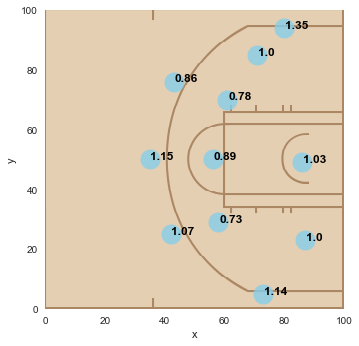

---------------------------------------------------------------
Ekpe Udoh
---------------------
---- 3 Pointers ----
Percentages
[0, 0, 0, 0, 0, 0]
---------------------
Expected Values
[0, 0, 0, 0, 0, 0]
---- 2 Pointers ----
Percentages
[0.515625, 0, 0, 0, 0, 0]
---------------------
Expected Values
[1.03125, 0, 0, 0, 0, 0]


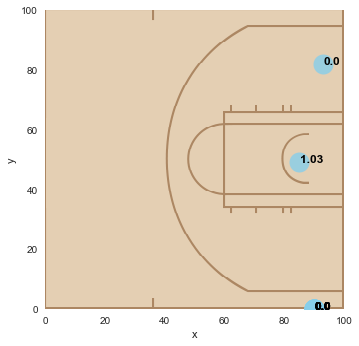

---------------------------------------------------------------
Jae Crowder
---------------------
---- 3 Pointers ----
Percentages
[0, 0.8, 0.2222222222222222, 0.23076923076923078, 0.42857142857142855, 0.3]
---------------------
Expected Values
[0, 2.4000000000000004, 0.6666666666666666, 0.6923076923076923, 1.2857142857142856, 0.8999999999999999]
---- 2 Pointers ----
Percentages
[0.6129032258064516, 0.5, 0.25, 0.16666666666666666, 0.4, 0.3333333333333333]
---------------------
Expected Values
[1.2258064516129032, 1.0, 0.5, 0.3333333333333333, 0.8, 0.6666666666666666]


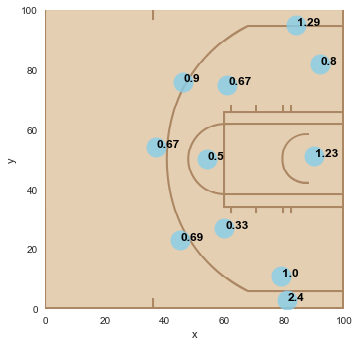

---------------------------------------------------------------
Joe Ingles
---------------------
---- 3 Pointers ----
Percentages
[0, 0.43478260869565216, 0.5333333333333333, 0.38095238095238093, 0.5135135135135135, 0.5098039215686274]
---------------------
Expected Values
[0, 1.3043478260869565, 1.6, 1.1428571428571428, 1.5405405405405403, 1.5294117647058822]
---- 2 Pointers ----
Percentages
[0.5670103092783505, 0.6, 0.5, 0.3333333333333333, 0, 0.38461538461538464]
---------------------
Expected Values
[1.134020618556701, 1.2, 1.0, 0.6666666666666666, 0, 0.7692307692307693]


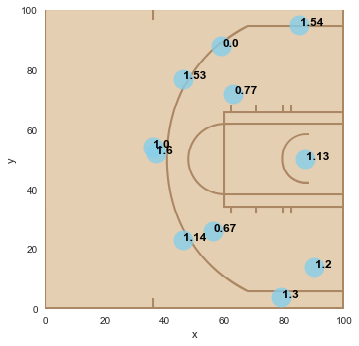

---------------------------------------------------------------
Joe Johnson
---------------------
---- 3 Pointers ----
Percentages
[0, 0.2, 0.0, 0.4444444444444444, 0.15789473684210525, 0.0]
---------------------
Expected Values
[0, 0.6000000000000001, 0.0, 1.3333333333333333, 0.47368421052631576, 0.0]
---- 2 Pointers ----
Percentages
[0.48936170212765956, 0.5, 0.5, 0.4117647058823529, 0, 0.4]
---------------------
Expected Values
[0.9787234042553191, 1.0, 1.0, 0.8235294117647058, 0, 0.8]


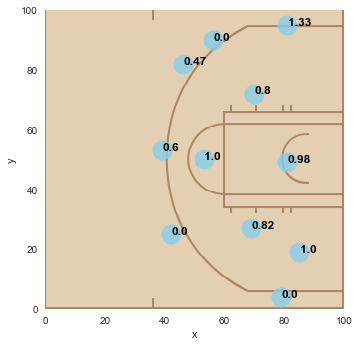

---------------------------------------------------------------
Jonas Jerebko
---------------------
---- 3 Pointers ----
Percentages
[0, 0.35294117647058826, 0.375, 0.25, 0.42857142857142855, 0.4]
---------------------
Expected Values
[0, 1.0588235294117647, 1.125, 0.75, 1.2857142857142856, 1.2000000000000002]
---- 2 Pointers ----
Percentages
[0.5487804878048781, 0.3333333333333333, 0.25, 0, 0.5, 0.0]
---------------------
Expected Values
[1.0975609756097562, 0.6666666666666666, 0.5, 0, 1.0, 0.0]


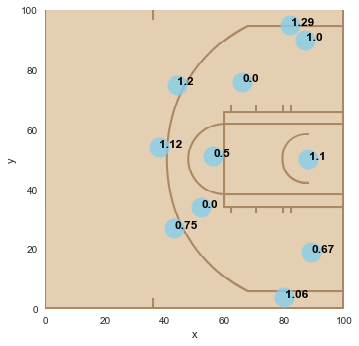

---------------------------------------------------------------
Raul Neto
---------------------
---- 3 Pointers ----
Percentages
[0, 0.3333333333333333, 0.0, 0.5, 0.42857142857142855, 0.375]
---------------------
Expected Values
[0, 1.0, 0.0, 1.5, 1.2857142857142856, 1.125]
---- 2 Pointers ----
Percentages
[0.5294117647058824, 0.0, 0, 0.25, 0, 0.5]
---------------------
Expected Values
[1.0588235294117647, 0.0, 0, 0.5, 0, 1.0]


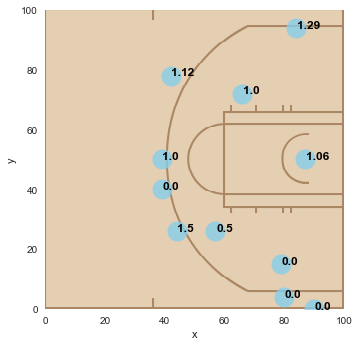

---------------------------------------------------------------
Ricky Rubio
---------------------
---- 3 Pointers ----
Percentages
[0, 0.25, 0.25, 0.5555555555555556, 0.45714285714285713, 0.45]
---------------------
Expected Values
[0, 0.75, 0.75, 1.6666666666666667, 1.3714285714285714, 1.35]
---- 2 Pointers ----
Percentages
[0.4892086330935252, 0.5, 0.4782608695652174, 0.3125, 0.2, 0.4457831325301205]
---------------------
Expected Values
[0.9784172661870504, 1.0, 0.9565217391304348, 0.625, 0.4, 0.891566265060241]


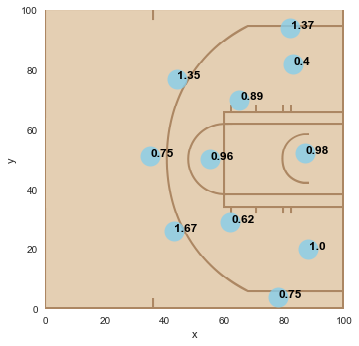

---------------------------------------------------------------
Rodney Hood
---------------------
---- 3 Pointers ----
Percentages
[0, 0.35714285714285715, 0.5, 0.3333333333333333, 0.17647058823529413, 0.4727272727272727]
---------------------
Expected Values
[0, 1.0714285714285714, 1.5, 1.0, 0.5294117647058824, 1.4181818181818182]
---- 2 Pointers ----
Percentages
[0.5681818181818182, 0.5, 0.5263157894736842, 0.3076923076923077, 0.3333333333333333, 0.5454545454545454]
---------------------
Expected Values
[1.1363636363636365, 1.0, 1.0526315789473684, 0.6153846153846154, 0.6666666666666666, 1.0909090909090908]


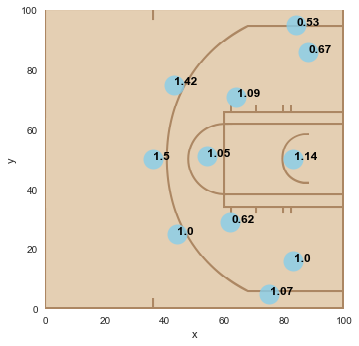

---------------------------------------------------------------
Royce O'Neale
---------------------
---- 3 Pointers ----
Percentages
[0, 0.45, 0.42857142857142855, 0.13333333333333333, 0.375, 0.16666666666666666]
---------------------
Expected Values
[0, 1.35, 1.2857142857142856, 0.4, 1.125, 0.5]
---- 2 Pointers ----
Percentages
[0.5194805194805194, 0, 0, 0.3333333333333333, 0.0, 0.5714285714285714]
---------------------
Expected Values
[1.0389610389610389, 0, 0, 0.6666666666666666, 0.0, 1.1428571428571428]


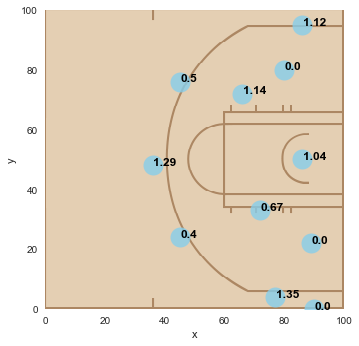

---------------------------------------------------------------
Rudy Gobert
---------------------
---- 3 Pointers ----
Percentages
[0, 0, 0, 0, 0, 0]
---------------------
Expected Values
[0, 0, 0, 0, 0, 0]
---- 2 Pointers ----
Percentages
[0.5555555555555556, 0, 0.5, 0, 0, 0.0]
---------------------
Expected Values
[1.1111111111111112, 0, 1.0, 0, 0, 0.0]


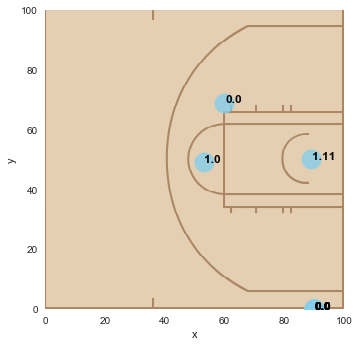

---------------------------------------------------------------
Thabo Sefolosha
---------------------
---- 3 Pointers ----
Percentages
[0, 0.45454545454545453, 1.0, 0.0, 0.5, 0.6]
---------------------
Expected Values
[0, 1.3636363636363635, 3.0, 0.0, 1.5, 1.7999999999999998]
---- 2 Pointers ----
Percentages
[0.6226415094339622, 0.5, 0.0, 0.0, 0.75, 0.38461538461538464]
---------------------
Expected Values
[1.2452830188679245, 1.0, 0.0, 0.0, 1.5, 0.7692307692307693]


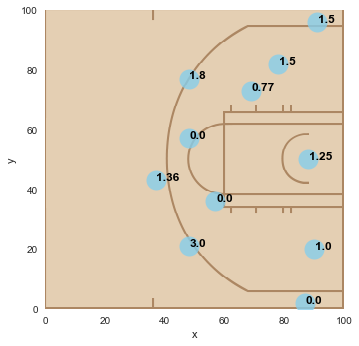

In [38]:
## HOME

# 3 pointers
PlayerIDs = np.unique(ShotsPD['shooter'])
PlayerNames = np.unique(ShotsPD['shooter_name'])
NumOPlayers = len(PlayerNames)
for Name in range(0,NumOPlayers):
    PercMadeDif3 = []
    NumShots = []
    NumMade = []
    ExpectedValue3 =[]
    AvLeft3 = []
    AvTop3 =[]
    PtVal3 = 3
    PtVal2 = 2
    PercMadeDif2 = []
    NumShots3 = []
    NumShots2 = []
    NumMade3 = []
    NumMade2 = []
    ExpectedValue2 =[]
    ExpectedValueRound = []
 
    AvLeft2 = []
    AvTop2 =[]
    
    for i in range(0,6):
        Location = ShotsPD[(ShotsPD['LocationCluster']==i) & (ShotsPD['ThreePt']==1) 
                           & ( ShotsPD['shooter_name'] == PlayerNames[Name])& ( ShotsPD['home/away'] == 0) ]     
        NumShots3.append(len(Location['made/missed']))
        NumMade3.append(len(Location[Location['made/missed']==1]))
        PercMade3 = 0
        if NumShots3[i] > 1:
            PercMade3 = NumMade3[i] / NumShots3[i]
            PercMadeDif3.append(PercMade3)
        else:
            PercMadeDif3.append(0)
    
        ExpectedValue3.append(PercMadeDif3[i]*PtVal3)
    
        AvLeft3.append(np.mean(Location['left']))
        AvTop3.append(np.mean(Location['top']))
        
        
        
    
        
        Location = ShotsPD[(ShotsPD['LocationCluster']==i) & (ShotsPD['ThreePt']==0) 
                           & ( ShotsPD['shooter_name'] == PlayerNames[Name]) & ( ShotsPD['home/away'] == 0) ]
        NumShots2.append(len(Location['made/missed']))
        NumMade2.append(len(Location[Location['made/missed']==1]))
        PercMade2 = 0
        if NumShots2[i] > 1:
                PercMade2 = NumMade2[i] / NumShots2[i]
                PercMadeDif2.append(PercMade2)
        else:
                PercMadeDif2.append(0)
        ExpectedValue2.append(PercMadeDif2[i]*PtVal2)
    
        AvLeft2.append(np.mean(Location['left']))
        AvTop2.append(np.mean(Location['top']))
        
    print('---------------------------------------------------------------')
    print(PlayerNames[Name])
    print('---------------------')
    print('---- 3 Pointers ----')
    print('Percentages')
    print(PercMadeDif3)
    print('---------------------')
    print('Expected Values')
    print(ExpectedValue3)
    

    
    print('---- 2 Pointers ----')
    print('Percentages')
    print(PercMadeDif2)
    print('---------------------')
    print('Expected Values')
    print(ExpectedValue2)
    
    for mm in range(0,len(ExpectedValue3)):
        if ExpectedValue3[mm] == 0:
            Extra = mm
    del ExpectedValue3[Extra]
    
    xx = np.isnan(AvLeft3)
    for mm in range(0, len(AvLeft3)):
        if  xx[mm] == True:
            DeleteVar = mm
    
    del AvLeft3[DeleteVar] 
    del AvTop3[DeleteVar]
    
    ExpectedValue = ExpectedValue3 + ExpectedValue2
    ExpectedValueRound = np.round_(ExpectedValue, decimals=2) 
    
    AvLefts = AvLeft3 + AvLeft2
    AvTops = AvTop3 + AvTop2
    
    for u in range(0,len(AvLefts)):
        if math.isnan(AvLefts[u]):
            AvLefts[u]=90
        if math.isnan(AvTops[u]):
            AvTops[u]= 0
        
    
    x = np.round(AvLefts,decimals=0)
    y = np.round(AvTops,decimals=0)
    valz = [str(ExpectedValueRound[0]),str(ExpectedValueRound[1]),str(ExpectedValueRound[2]),
            str(ExpectedValueRound[3]),str(ExpectedValueRound[4]),str(ExpectedValueRound[5]),
            str(ExpectedValueRound[6]),str(ExpectedValueRound[7]),str(ExpectedValueRound[8]),
            str(ExpectedValueRound[9]),str(ExpectedValueRound[10])]
    df = pd.DataFrame({
    'x': x,
    'y': y,
    'group': valz
    })
 
    p1=sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
    for line in range(0,df.shape[0]):
        p1.text(df.x[line]+0.2, df.y[line], df.group[line], horizontalalignment='left', 
                size='medium', color='black', weight='semibold')
    plt.imshow(img, zorder=0, extent=[0, 100, 0, 100.0])
    plt.grid(False)

    plt.show()

---------------------------------------------------------------
Alec Burks
---------------------
---- 3 Pointers ----
Percentages
[0, 0.5555555555555556, 0.3125, 0.2916666666666667, 0.5, 0.5]
---------------------
Expected Values
[0, 1.6666666666666667, 0.9375, 0.875, 1.5, 1.5]
---- 2 Pointers ----
Percentages
[0.5875, 0, 0.3333333333333333, 0.2857142857142857, 0, 0.5625]
---------------------
Expected Values
[1.175, 0, 0.6666666666666666, 0.5714285714285714, 0, 1.125]


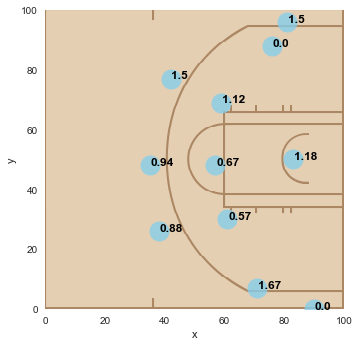

---------------------------------------------------------------
Derrick Favors
---------------------
---- 3 Pointers ----
Percentages
[0, 0.17647058823529413, 0, 0, 0.18181818181818182, 0]
---------------------
Expected Values
[0, 0.5294117647058824, 0, 0, 0.5454545454545454, 0]
---- 2 Pointers ----
Percentages
[0.7024793388429752, 0.375, 0.4634146341463415, 0.3125, 1.0, 0.23529411764705882]
---------------------
Expected Values
[1.4049586776859504, 0.75, 0.926829268292683, 0.625, 2.0, 0.47058823529411764]


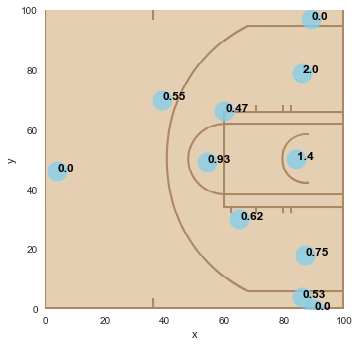

---------------------------------------------------------------
Donovan Mitchell
---------------------
---- 3 Pointers ----
Percentages
[0, 0.358974358974359, 0.32727272727272727, 0.25806451612903225, 0.6153846153846154, 0.2619047619047619]
---------------------
Expected Values
[0, 1.0769230769230769, 0.9818181818181818, 0.7741935483870968, 1.8461538461538463, 0.7857142857142858]
---- 2 Pointers ----
Percentages
[0.5590277777777778, 0.75, 0.37209302325581395, 0.29545454545454547, 0.3333333333333333, 0.5]
---------------------
Expected Values
[1.1180555555555556, 1.5, 0.7441860465116279, 0.5909090909090909, 0.6666666666666666, 1.0]


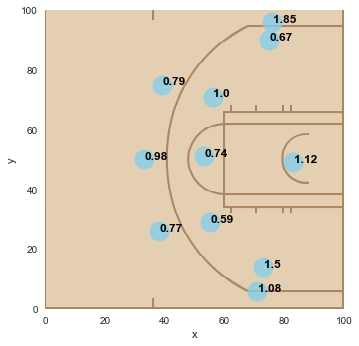

---------------------------------------------------------------
Ekpe Udoh
---------------------
---- 3 Pointers ----
Percentages
[0, 0, 0, 0, 0, 0]
---------------------
Expected Values
[0, 0, 0, 0, 0, 0]
---- 2 Pointers ----
Percentages
[0.5625, 0, 0, 0.0, 0, 0]
---------------------
Expected Values
[1.125, 0, 0, 0.0, 0, 0]


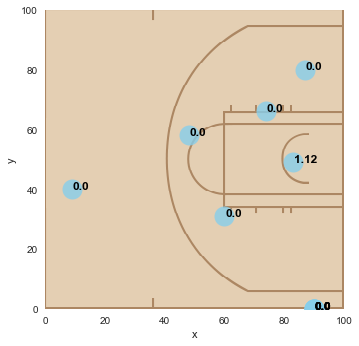

---------------------------------------------------------------
Jae Crowder
---------------------
---- 3 Pointers ----
Percentages
[0, 0.42857142857142855, 0.36363636363636365, 0.3, 0.05555555555555555, 0.25]
---------------------
Expected Values
[0, 1.2857142857142856, 1.0909090909090908, 0.8999999999999999, 0.16666666666666666, 0.75]
---- 2 Pointers ----
Percentages
[0.5344827586206896, 0.5, 0.4, 0.25, 0.0, 0.2857142857142857]
---------------------
Expected Values
[1.0689655172413792, 1.0, 0.8, 0.5, 0.0, 0.5714285714285714]


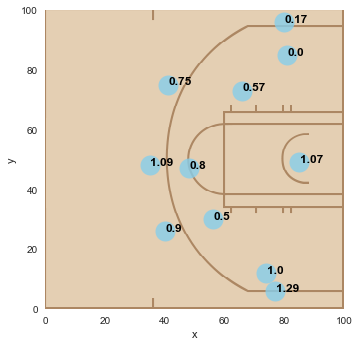

---------------------------------------------------------------
Joe Ingles
---------------------
---- 3 Pointers ----
Percentages
[0, 0.4838709677419355, 0.37037037037037035, 0.35294117647058826, 0.4782608695652174, 0.3617021276595745]
---------------------
Expected Values
[0, 1.4516129032258065, 1.1111111111111112, 1.0588235294117647, 1.4347826086956523, 1.0851063829787235]
---- 2 Pointers ----
Percentages
[0.5576923076923077, 0.4, 0.375, 0.3, 0.0, 0.3]
---------------------
Expected Values
[1.1153846153846154, 0.8, 0.75, 0.6, 0.0, 0.6]


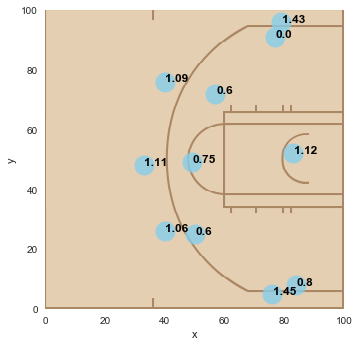

---------------------------------------------------------------
Joe Johnson
---------------------
---- 3 Pointers ----
Percentages
[0, 0.45454545454545453, 0.6666666666666666, 0.2, 0.5, 0.2222222222222222]
---------------------
Expected Values
[0, 1.3636363636363635, 2.0, 0.6000000000000001, 1.5, 0.6666666666666666]
---- 2 Pointers ----
Percentages
[0.6785714285714286, 0.5, 0.8, 0.5714285714285714, 0.0, 0.3333333333333333]
---------------------
Expected Values
[1.3571428571428572, 1.0, 1.6, 1.1428571428571428, 0.0, 0.6666666666666666]


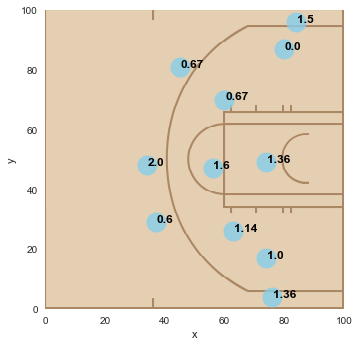

---------------------------------------------------------------
Jonas Jerebko
---------------------
---- 3 Pointers ----
Percentages
[0, 0.5769230769230769, 0.16666666666666666, 0.4166666666666667, 0.5217391304347826, 0.3125]
---------------------
Expected Values
[0, 1.7307692307692306, 0.5, 1.25, 1.5652173913043477, 0.9375]
---- 2 Pointers ----
Percentages
[0.5352112676056338, 0.0, 0, 1.0, 0.0, 0.3333333333333333]
---------------------
Expected Values
[1.0704225352112675, 0.0, 0, 2.0, 0.0, 0.6666666666666666]


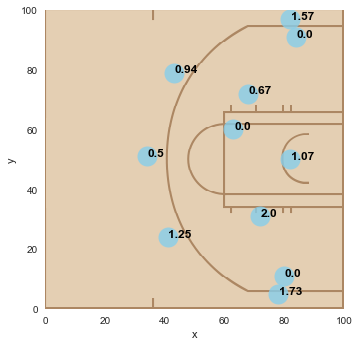

---------------------------------------------------------------
Raul Neto
---------------------
---- 3 Pointers ----
Percentages
[0, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.5, 0]
---------------------
Expected Values
[0, 2.0, 1.0, 1.0, 1.5, 0]
---- 2 Pointers ----
Percentages
[0.5294117647058824, 0.5, 0, 0.0, 0, 0.0]
---------------------
Expected Values
[1.0588235294117647, 1.0, 0, 0.0, 0, 0.0]


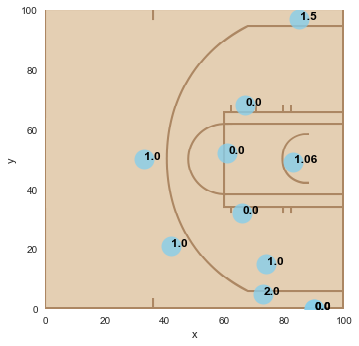

---------------------------------------------------------------
Ricky Rubio
---------------------
---- 3 Pointers ----
Percentages
[0, 0.2692307692307692, 0.20833333333333334, 0.29411764705882354, 0.3548387096774194, 0.3333333333333333]
---------------------
Expected Values
[0, 0.8076923076923077, 0.625, 0.8823529411764706, 1.064516129032258, 1.0]
---- 2 Pointers ----
Percentages
[0.44660194174757284, 0.42857142857142855, 0.5, 0.5333333333333333, 0.75, 0.3548387096774194]
---------------------
Expected Values
[0.8932038834951457, 0.8571428571428571, 1.0, 1.0666666666666667, 1.5, 0.7096774193548387]


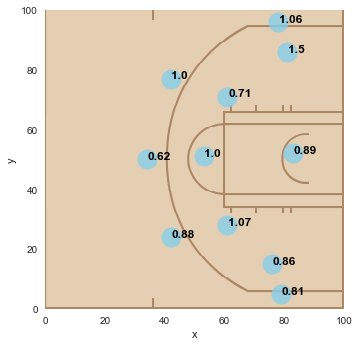

---------------------------------------------------------------
Rodney Hood
---------------------
---- 3 Pointers ----
Percentages
[0, 0.46153846153846156, 0.3103448275862069, 0.21052631578947367, 0.4, 0.3888888888888889]
---------------------
Expected Values
[0, 1.3846153846153846, 0.9310344827586208, 0.631578947368421, 1.2000000000000002, 1.1666666666666667]
---- 2 Pointers ----
Percentages
[0.46, 0.25, 0.38461538461538464, 0.21739130434782608, 1.0, 0.42857142857142855]
---------------------
Expected Values
[0.92, 0.5, 0.7692307692307693, 0.43478260869565216, 2.0, 0.8571428571428571]


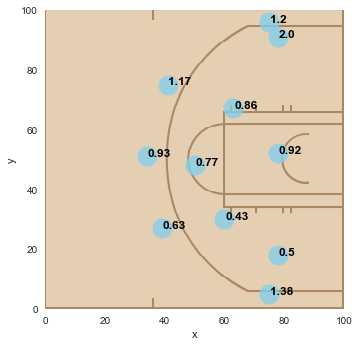

---------------------------------------------------------------
Royce O'Neale
---------------------
---- 3 Pointers ----
Percentages
[0, 0.2, 0.25, 0.3333333333333333, 0.36363636363636365, 0.6666666666666666]
---------------------
Expected Values
[0, 0.6000000000000001, 0.75, 1.0, 1.0909090909090908, 2.0]
---- 2 Pointers ----
Percentages
[0.42028985507246375, 0, 0.6666666666666666, 0.5, 0, 0.6]
---------------------
Expected Values
[0.8405797101449275, 0, 1.3333333333333333, 1.0, 0, 1.2]


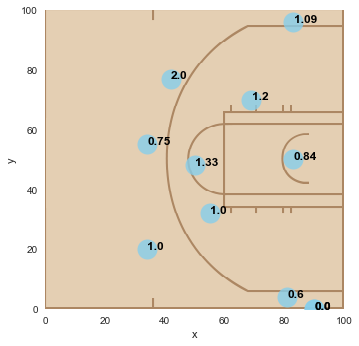

---------------------------------------------------------------
Rudy Gobert
---------------------
---- 3 Pointers ----
Percentages
[0, 0, 0, 0, 0, 0]
---------------------
Expected Values
[0, 0, 0, 0, 0, 0]
---- 2 Pointers ----
Percentages
[0.706140350877193, 0, 0.25, 0, 0, 0.5]
---------------------
Expected Values
[1.412280701754386, 0, 0.5, 0, 0, 1.0]


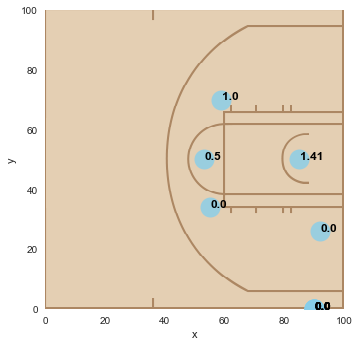

---------------------------------------------------------------
Thabo Sefolosha
---------------------
---- 3 Pointers ----
Percentages
[0, 0.4444444444444444, 0.0, 0.2727272727272727, 0.35714285714285715, 0.2222222222222222]
---------------------
Expected Values
[0, 1.3333333333333333, 0.0, 0.8181818181818181, 1.0714285714285714, 0.6666666666666666]
---- 2 Pointers ----
Percentages
[0.6031746031746031, 0.0, 0.6666666666666666, 0.25, 0.5, 0.3333333333333333]
---------------------
Expected Values
[1.2063492063492063, 0.0, 1.3333333333333333, 0.5, 1.0, 0.6666666666666666]


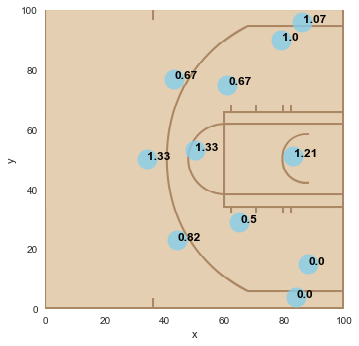

In [39]:
## Away

# 3 pointers
PlayerIDs = np.unique(ShotsPD['shooter'])
PlayerNames = np.unique(ShotsPD['shooter_name'])
NumOPlayers = len(PlayerNames)
for Name in range(0,NumOPlayers):
    PercMadeDif3 = []
    NumShots = []
    NumMade = []
    ExpectedValue3 =[]
    AvLeft3 = []
    AvTop3 =[]
    PtVal3 = 3
    PtVal2 = 2
    PercMadeDif2 = []
    NumShots3 = []
    NumShots2 = []
    NumMade3 = []
    NumMade2 = []
    ExpectedValue2 =[]
    ExpectedValueRound = []
 
    AvLeft2 = []
    AvTop2 =[]
    
    for i in range(0,6):
        Location = ShotsPD[(ShotsPD['LocationCluster']==i) & (ShotsPD['ThreePt']==1) 
                           & ( ShotsPD['shooter_name'] == PlayerNames[Name])& ( ShotsPD['home/away'] == 1) ]     
        NumShots3.append(len(Location['made/missed']))
        NumMade3.append(len(Location[Location['made/missed']==1]))
        PercMade3 = 0
        if NumShots3[i] > 1:
            PercMade3 = NumMade3[i] / NumShots3[i]
            PercMadeDif3.append(PercMade3)
        else:
            PercMadeDif3.append(0)
    
        ExpectedValue3.append(PercMadeDif3[i]*PtVal3)
    
        AvLeft3.append(np.mean(Location['left']))
        AvTop3.append(np.mean(Location['top']))
        
        
        
    
        
        Location = ShotsPD[(ShotsPD['LocationCluster']==i) & (ShotsPD['ThreePt']==0) 
                           & ( ShotsPD['shooter_name'] == PlayerNames[Name]) & ( ShotsPD['home/away'] == 1) ]
        NumShots2.append(len(Location['made/missed']))
        NumMade2.append(len(Location[Location['made/missed']==1]))
        PercMade2 = 0
        if NumShots2[i] > 1:
                PercMade2 = NumMade2[i] / NumShots2[i]
                PercMadeDif2.append(PercMade2)
        else:
                PercMadeDif2.append(0)
        ExpectedValue2.append(PercMadeDif2[i]*PtVal2)
    
        AvLeft2.append(np.mean(Location['left']))
        AvTop2.append(np.mean(Location['top']))
        
    print('---------------------------------------------------------------')
    print(PlayerNames[Name])
    print('---------------------')
    print('---- 3 Pointers ----')
    print('Percentages')
    print(PercMadeDif3)
    print('---------------------')
    print('Expected Values')
    print(ExpectedValue3)
    

    
    print('---- 2 Pointers ----')
    print('Percentages')
    print(PercMadeDif2)
    print('---------------------')
    print('Expected Values')
    print(ExpectedValue2)
    
    for mm in range(0,len(ExpectedValue3)):
        if ExpectedValue3[mm] == 0:
            Extra = mm
    del ExpectedValue3[Extra]
    
    xx = np.isnan(AvLeft3)
    for mm in range(0, len(AvLeft3)):
        if  xx[mm] == True:
            DeleteVar = mm
    
    del AvLeft3[DeleteVar] 
    del AvTop3[DeleteVar]
    
    ExpectedValue = ExpectedValue3 + ExpectedValue2
    ExpectedValueRound = np.round_(ExpectedValue, decimals=2) 
    
    AvLefts = AvLeft3 + AvLeft2
    AvTops = AvTop3 + AvTop2
    
    for u in range(0,len(AvLefts)):
        if math.isnan(AvLefts[u]):
            AvLefts[u]=90
        if math.isnan(AvTops[u]):
            AvTops[u]= 0
        
    
    x = np.round(AvLefts,decimals=0)
    y = np.round(AvTops,decimals=0)
    valz = [str(ExpectedValueRound[0]),str(ExpectedValueRound[1]),str(ExpectedValueRound[2]),
            str(ExpectedValueRound[3]),str(ExpectedValueRound[4]),str(ExpectedValueRound[5]),
            str(ExpectedValueRound[6]),str(ExpectedValueRound[7]),str(ExpectedValueRound[8]),
            str(ExpectedValueRound[9]),str(ExpectedValueRound[10])]
    df = pd.DataFrame({
    'x': x,
    'y': y,
    'group': valz
    })
 
    p1=sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
    for line in range(0,df.shape[0]):
        p1.text(df.x[line]+0.2, df.y[line], df.group[line], horizontalalignment='left', 
                size='medium', color='black', weight='semibold')
    
    plt.imshow(img, zorder=0, extent=[0, 100, 0, 100.0])
    plt.grid(False)

    plt.show()

** Conclusions**

From this, we can see that some players shoot different shots at much different expected values based on whether they are home or away. This could come from players having more nerves at away games and shooting worse altogether, or from being more comfortable with certain courts and stadiums. In the comparison below, we can see that Ricky Rubio is a much better 3-point shooter at home; but interestingly enough, he shoots the baseline jumper 3x better away than at home. It is interesting to think players can shoot better or worse just depending on whether it is a home or an away game.

![Ricky Rubio](RickyComparison.jpeg)

### Score Prediction 

Finally, we were able to look at predicting a game based on the knowledge of the shot attempts to guess the team score and individual scores. We actually did quite well by looking at the boxscore listed below. This was the first game of the season. We over predicted Donovan Mitchell's score, probably as this was his first game in the NBA, and he may have shot worse due to nerves and getting used to the flow. Alec Burks was playing better at the time,  so he actually did better than we predicted. We were able to decently predict a score based upon the expected values we found. However, our methods don't take into account free throws, so our final scores will be a little off depending on free throws.

We were able to be within 7 points for each player. The model predicted Joe Johnson's score perfectly while we were 7 off of Alec Burks actual total. We were 8 short of the team total.

In [40]:
GameOfInterest = 1
GameX = ShotsPD[ShotsPD['game'] == GameOfInterest]

In [41]:
# Predicting a game
# 3 pointers
PlayerIDs = np.unique(GameX['shooter'])
PlayerNames = np.unique(GameX['shooter_name'])
NumOPlayers = len(PlayerNames)
TotalPts = []
PlayerToalPts = []
PlayerToalPtsActual = []
TotalPtsActual = []
TotalTotalPts = []
for Name in range(0,NumOPlayers):
    PercMadeDif3 = []
    NumShots = []
    NumMade = []
    ExpectedValue3 =[]
    PtVal3 = 3
    PtVal2 = 2
    PercMadeDif2 = []
    NumShots3 = []
    NumShots2 = []
    NumMade3 = []
    NumMade2 = []
    ExpectedValue2 =[]
    ExpectedValueRound = []

    
    
    NumShotsRecreate3 = []
    NumShotsRecreate2 = []
    LocationRecreate2 = []
    LocationRecreate3 = []
    ExpectedPoints3Recreate = []
    ExpectedPoints2Recreate= []
    PlayerToalPts = []
    
    
    NumShotsRecreate3Actual = []
    NumShotsRecreate2Actual = []
    LocationRecreate2Actual = []
    LocationRecreate3Actual = []
    ExpectedPoints3RecreateActual = []
    ExpectedPoints2RecreateActual= []
    PlayerToalPts = []
     
    
    for i in range(0,6):
        Location = ShotsPD[(ShotsPD['LocationCluster']==i) & (ShotsPD['ThreePt']==1) 
                           & ( ShotsPD['shooter_name'] == PlayerNames[Name])]     
        NumShots3.append(len(Location['made/missed']))
        NumMade3.append(len(Location[Location['made/missed']==1]))
        PercMade3 = 0
        if NumShots3[i] > 1:
            PercMade3 = NumMade3[i] / NumShots3[i]
            PercMadeDif3.append(PercMade3)
        else:
            PercMadeDif3.append(0)
    
        ExpectedValue3.append(PercMadeDif3[i]*PtVal3)
    
        AvLeft3.append(np.mean(Location['left']))
        AvTop3.append(np.mean(Location['top']))
        
        
        
    
        
        Location = ShotsPD[(ShotsPD['LocationCluster']==i) & (ShotsPD['ThreePt']==0) 
                           & ( ShotsPD['shooter_name'] == PlayerNames[Name])]
        NumShots2.append(len(Location['made/missed']))
        NumMade2.append(len(Location[Location['made/missed']==1]))
        PercMade2 = 0
        if NumShots2[i] > 1:
                PercMade2 = NumMade2[i] / NumShots2[i]
                PercMadeDif2.append(PercMade2)
        else:
                PercMadeDif2.append(0)
        ExpectedValue2.append(PercMadeDif2[i]*PtVal2)
    
        AvLeft2.append(np.mean(Location['left']))
        AvTop2.append(np.mean(Location['top']))
        

              
    
    
                         
                         
                         
                         
    
    

    
    
    for i in range(0,6):
        LocationRecreate3 = GameX[(GameX['LocationCluster']==i)& (GameX['ThreePt']==1) 
                                  & ( GameX['shooter_name'] == PlayerNames[Name])] 
        NumShotsRecreate3.append(len(LocationRecreate3['made/missed']))
        ExpectedPoints3Recreate.append(NumShotsRecreate3[i]*ExpectedValue3[i])
        
    for i in range(0,6):
        LocationRecreate2 = GameX[(GameX['LocationCluster']==i)& (GameX['ThreePt']==0) 
                                  & ( GameX['shooter_name'] == PlayerNames[Name])] 
        NumShotsRecreate2.append(len(LocationRecreate2['made/missed']))
        ExpectedPoints2Recreate.append(NumShotsRecreate2[i]*ExpectedValue2[i])
       
    
    Player3pts = np.sum(ExpectedPoints3Recreate)
    Player2pts = np.sum(ExpectedPoints2Recreate)
    
    PlayerToalPts = Player3pts + Player2pts
    
    TotalPts.append(int(PlayerToalPts))
    
    
    
    
    ## Actual Results of the Game
    
    for i in range(0,6):
        LocationRecreate3Actual = GameX[(GameX['LocationCluster']==i)& (GameX['ThreePt']==1) 
                                        & ( GameX['shooter_name'] == PlayerNames[Name]) 
                                        & ( GameX['made/missed'] == 1)] 
        NumShotsRecreate3Actual.append(len(LocationRecreate3Actual['made/missed']))
        ExpectedPoints3RecreateActual.append(NumShotsRecreate3Actual[i]*3)
        
    for i in range(0,6):
        LocationRecreate2Actual = GameX[(GameX['LocationCluster']==i)& (GameX['ThreePt']==0) 
                                        & ( GameX['shooter_name'] == PlayerNames[Name]) 
                                        & ( GameX['made/missed'] == 1)] 
        NumShotsRecreate2Actual.append(len(LocationRecreate2Actual['made/missed']))
        ExpectedPoints2RecreateActual.append(NumShotsRecreate2Actual[i]*2)
    
    
    Player3ptsActual = np.sum(ExpectedPoints3RecreateActual)
    Player2ptsActual = np.sum(ExpectedPoints2RecreateActual)
    
    PlayerToalPtsActual = Player3ptsActual + Player2ptsActual
    
    TotalPtsActual.append(int(PlayerToalPtsActual))
    
    
    
    print('---------------------------------------------------------------')
    print(PlayerNames[Name])
    print('Predicted: ' + str(int(PlayerToalPts)))
    print('Actual: ' + str(PlayerToalPtsActual))
    
    
    
TotalTotalPts = np.sum(TotalPts)
TotalTotalPtsActual = np.sum(TotalPtsActual)
print('---------------------------------------------------------------')
print('---------------------------------------------------------------')
print('Final Jazz Score:')
print('Predicted: ' + str(TotalTotalPts))
print('Actual: ' + str(TotalTotalPtsActual))

    

---------------------------------------------------------------
Alec Burks
Predicted: 9
Actual: 16
---------------------------------------------------------------
Derrick Favors
Predicted: 13
Actual: 14
---------------------------------------------------------------
Donovan Mitchell
Predicted: 12
Actual: 6
---------------------------------------------------------------
Ekpe Udoh
Predicted: 0
Actual: 0
---------------------------------------------------------------
Joe Ingles
Predicted: 7
Actual: 11
---------------------------------------------------------------
Joe Johnson
Predicted: 10
Actual: 10
---------------------------------------------------------------
Ricky Rubio
Predicted: 8
Actual: 7
---------------------------------------------------------------
Rodney Hood
Predicted: 4
Actual: 6
---------------------------------------------------------------
Rudy Gobert
Predicted: 11
Actual: 14
---------------------------------------------------------------
Thabo Sefolosha
Predicted: 7
Act

![JazzFirstGame](JazzFirstGame.jpeg)

## Conclusion:

We successfully were able to:
- Acquire the data needed from ESPN
- Clean the data to extract the needed values for analysis
- Cluster the shots into natural groupings
- Look at expected values for both the team and individuals
- Perform significance testing on the data
- Compare expected values between home and away games
- Predict a Jazz game outcome using a model

### Ideas for future study:

 - Effects of fatigue and overshooting in locations
 
 - Correlation between shot selection and winning
 
 - Compare Jazz's losing streak with winning streak
 
 - Predict fouls and foul shots
 
 - Evolution of Donovan Mitchell over the season